In [ ]:
#resources 
#https://towardsdatascience.com/building-an-image-color-analyzer-using-python-12de6b0acf74

In [15]:
from collections import Counter
from sklearn.cluster import KMeans
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import cv2
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import colorsys
import os
from fake_useragent import UserAgent

from time import sleep
import json

import contractions
import spacy
#from spacy.tokenizer import Tokenizer
import en_core_web_sm
import nltk
#from nltk.stem import WordNetLemmatizer
from nltk import bigrams, trigrams
from bs4 import BeautifulSoup, SoupStrainer
from urllib.request import Request, urlopen
import requests
import string
import regex as re
import collections
from lxml import etree
import csv 
import pandas as pd


In [2]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
ua = UserAgent()
userAgent = ua.random
find_company_urls = False
write_company_csv = False

In [3]:
def rgb_to_hex(rgb_color):
    hex_color = "#"
    for i in rgb_color:
        i = int(i)
        hex_color += ("{:02x}".format(i))
    return hex_color

def prep_image(raw_img):
    modified_img = cv2.resize(raw_img, (900, 600), interpolation = cv2.INTER_AREA)
    modified_img = modified_img.reshape(modified_img.shape[0]*modified_img.shape[1], 3)
    return modified_img

def color_analysis(img, url, k=6):
    
    clf = KMeans(n_clusters = k)
    color_labels = clf.fit_predict(img)
    center_colors = clf.cluster_centers_    
    counts = Counter(color_labels)
    ordered_colors = [center_colors[i].round(3).tolist() for i in counts.keys()]
    hex_colors = [rgb_to_hex(ordered_colors[i]) for i in counts.keys()]    
    plt.figure(figsize = (12, 8))
    plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    plt.title('color proportions from {u}'.format(u=url))
    plt.savefig('./plots/pie-' + url.replace('.', '-') + '.png')
    
    
    
    color_array = np.array(list(counts.values()))
    color_proportion = (color_array/sum(color_array)).round(3).tolist()
 
    
    color_dict = {}
    
    color_dict['centroids_rgb'] = ordered_colors
    color_dict['centroids_hex'] = hex_colors
    color_dict['color_counts'] = color_array.tolist()
    color_dict['color_proportion'] = color_proportion
    
    hsv = [list(colorsys.rgb_to_hsv(c[0], c[1], c[2])) for c in color_dict['centroids_rgb']]
    color_dict['centroids_hsv']=hsv
    
    #print(hex_colors)
    return color_dict 

In [4]:
def get_paragraph_text(url, hdr):
    
    try:
        
        req = Request(url,headers=hdr)
        page = urlopen(req)
    
    except:
        
        print("http failed, trying https:")
        
        try:
            url = url.replace('http:', 'https:')
            req = Request(url,headers=hdr)
            page = urlopen(req)
        
        except Exception as e:
            print("substitution of https also failed. Error is {}".format(e))
            
    else:
   
        soup = BeautifulSoup(page, 'html.parser')

        p=soup.find_all('p')
        text = ' '.join(t.get_text() for t in p)

        return text

class TextPreprocessor(object):
    def __init__(self):
        """
        TBD
        """

    def preprocess_df(self, df):
        return df.apply(self._preprocess_text)

    def preprocess_text(self, text):
        doc = nlp(text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)

        return self._lemmatize(removed_stop_words)

    def _remove_punct(self, doc):
        return [t for t in doc if t.text not in string.punctuation]

    def _remove_stop_words(self, doc):
        return [t for t in doc if not t.is_stop]

    def _lemmatize(self, doc):
        
        lemma_text = ' '.join([t.lemma_ for t in doc])
        
        return re.sub('\s+',' ',lemma_text)
        


In [ ]:
if find_company_urls:
    
    r = requests.get("https://www.bcorporation.net/sitemap/sitemap-0.xml")
    root = etree.fromstring(r.content)
    d='find-a-b-corp'
    hdr = {'User-Agent':str(ua.chrome)}

    urls=[]

    for sitemap in root:
        children = sitemap.getchildren()

        if 'find-a-b-corp/company/' in children[0].text:
            urls.append(children[0].text)

    company_urls=[]

    for idx, url in enumerate(urls):

        try:

            url_split=url.split('find-a-b-corp')

            redirect=url_split[0] + 'en-us/' + d + url_split[1]

            if '/en-us/en-us' not in redirect:

                company=redirect.split('/company/')[-1]



                req = Request(redirect,headers=hdr)
                page = urlopen(req)
                soup = BeautifulSoup(page, 'html.parser')


                #company_site=soup.text.split("Website")[1].split('www.')[1].split('.')[0]
                for ele in soup.text.split("Website")[1].split('www.'):

                    #find the first (non empty) part of the url after "www." since this will contain the beginning of the
                    #company's website
                    if len(ele) > 0:
                        company_site = ele.split('.')[0]
                        break



                company_url=soup.find('a', attrs={'href': re.compile(company_site)}).get('href')
                company_urls.append(company_url)
        except Exception as e:
            print(e, url)

    if write_company_csv:
        # opening the csv file in 'w+' mode
        file = open('b-corp-companies.csv', 'w+', newline ='')

        # writing the data into the file
        for element in company_urls:
            file.write(element + "\n")
        file.close()




In [ ]:
#company_urls = ['www.uber.com', 'www.lyft.com', 'www.doordash.com']
#company_urls = ['www.bsw.com']
#urls = ['www.lyft.com']
#check out https://github.com/robinreni96/Font_Recognition-DeepFont

In [5]:
with open('b-corp-companies.csv', newline='') as f:
    reader = csv.reader(f)
    company_urls = list(reader)

In [6]:
#company_urls= company_urls[653:]
#company_urls
#len(company_urls)
company_urls= company_urls[1137:]
#company_urls[0]

['https://www.dekrat.nl']

In [7]:
def take_screenshot(url, driver):
    
    try:
        
        url = url.split('https://')[1]
        
        sleep(2)
        driver.get('https://' + url)
        #driver.get(url)
        sleep(2)


        S = lambda X: driver.execute_script('return document.body.parentNode.scroll'+X)
        driver.set_window_size(S('Width'),S('Height')) # May need manual adjustment

        el = driver.find_element(By.TAG_NAME, value='body')
        el.screenshot('./site-screenshots/'+ url.replace('.', '-') + '.png')
        
    except Exception as e:
        
        print("url {url} error {e}".format(url=url, e=e))
    



====== WebDriver manager ======
Current google-chrome version is 101.0.4951
Get LATEST chromedriver version for 101.0.4951 google-chrome
Driver [/Users/amywinecoff/.wdm/drivers/chromedriver/mac64/101.0.4951.41/chromedriver] found in cache


['https://www.dekrat.nl']
url www.dekrat.nl error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.causestrategypartners.com']
url www.causestrategypartners.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.seedsystems.net']


[ WARN:0@58.737] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-dekrat-nl.png'): can't open/read file: check file path/integrity
[ WARN:0@58.738] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-causestrategypartners-com.png'): can't open/read file: check file path/integrity


['https://www.brownbread.co.nz']
url www.brownbread.co.nz error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.startsomegood.com']


[ WARN:0@60.919] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-brownbread-co-nz.png'): can't open/read file: check file path/integrity


['https://www.habitech.it']
url www.habitech.it error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.pymwymic.com']
url www.pymwymic.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.polkura.cl']


[ WARN:0@62.680] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-habitech-it.png'): can't open/read file: check file path/integrity
[ WARN:0@62.681] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-pymwymic-com.png'): can't open/read file: check file path/integrity


['https://changecatalyst.co']
['https://www.tyf.com']
['https://www.apdscorporate.com']
url www.apdscorporate.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['/en-us']
url /en-us error list index out of range
['https://www.eoproducts.com']
url www.eoproducts.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://suncommon.com']


[ WARN:0@69.004] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-apdscorporate-com.png'): can't open/read file: check file path/integrity
[ WARN:0@69.006] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-eoproducts-com.png'): can't open/read file: check file path/integrity


['https://theteaspot.com/']
url theteaspot.com/ error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.theglutenfreebar.com']
url www.theglutenfreebar.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://oneseventeenmedia.com']


[ WARN:0@71.730] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/theteaspot-com/.png'): can't open/read file: check file path/integrity
[ WARN:0@71.732] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-theglutenfreebar-com.png'): can't open/read file: check file path/integrity


['https://www.countrylifevitamins.com']
url www.countrylifevitamins.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://eqinvestors.co.uk']


[ WARN:0@73.609] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-countrylifevitamins-com.png'): can't open/read file: check file path/integrity


['https://www.tsiconsultancy.com']
url www.tsiconsultancy.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.sweetlivity.com']
url www.sweetlivity.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.fully.com']
url www.fully.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.kentemploymentlaw.com']
url www.kentemploymentlaw.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.metowe.com']


[ WARN:0@75.851] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-tsiconsultancy-com.png'): can't open/read file: check file path/integrity
[ WARN:0@75.852] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-sweetlivity-com.png'): can't open/read file: check file path/integrity
[ WARN:0@75.852] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-fully-com.png'): can't open/read file: check file path/integrity
[ WARN:0@75.852] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-kentemploymentlaw-com.png'): can't open/read file: check file path/integrity


['https://www.junxion.com']
['https://www.genuinehealth.com']
['https://www.feroniaforests.com']
url www.feroniaforests.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://dolphinblue.com']
url dolphinblue.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://bloominpromotions.com']
url bloominpromotions.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.tonyschocolonely.com']
url www.tonyschocolonely.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'c

[ WARN:0@83.068] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-feroniaforests-com.png'): can't open/read file: check file path/integrity
[ WARN:0@83.071] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/dolphinblue-com.png'): can't open/read file: check file path/integrity
[ WARN:0@83.071] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/bloominpromotions-com.png'): can't open/read file: check file path/integrity
[ WARN:0@83.071] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-tonyschocolonely-com.png'): can't open/read file: check file path/integrity
[ WARN:0@83.072] global /Users/runner/work/opencv-python/o

['https://www.saberespoder.com']
url www.saberespoder.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.trilliuminvest.com']
url www.trilliuminvest.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.leibowitzpictures.com']


[ WARN:0@85.675] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-saberespoder-com.png'): can't open/read file: check file path/integrity
[ WARN:0@85.676] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-trilliuminvest-com.png'): can't open/read file: check file path/integrity


['https://www.digitopia.agency']
['https://imperative.com']
url imperative.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://onewater.org.uk']


[ WARN:0@89.685] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/imperative-com.png'): can't open/read file: check file path/integrity


['https://netraising.com']
['https://www.pranaorganic.ca']
url www.pranaorganic.ca error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://tgwstudio.com']
url tgwstudio.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.genashtim.com']


[ WARN:0@94.299] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-pranaorganic-ca.png'): can't open/read file: check file path/integrity
[ WARN:0@94.301] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/tgwstudio-com.png'): can't open/read file: check file path/integrity


['https://www.rmagency.com']
url www.rmagency.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://corporate.danone.com.ar/ar/descubri/nuestros-negocios/aguas']
url corporate.danone.com.ar/ar/descubri/nuestros-negocios/aguas error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://coloradocap.com']
url coloradocap.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.sustypacific.com']
url www.sustypacific.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColo

[ WARN:0@96.491] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-rmagency-com.png'): can't open/read file: check file path/integrity
[ WARN:0@96.492] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/corporate-danone-com-ar/ar/descubri/nuestros-negocios/aguas.png'): can't open/read file: check file path/integrity
[ WARN:0@96.492] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/coloradocap-com.png'): can't open/read file: check file path/integrity
[ WARN:0@96.493] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-sustypacific-com.png'): can't open/read file: check file path/integrity
[ WARN:0@96.493] global /Users

['https://www.numitea.com']
['https://flipgive.com']


/var/folders/6j/rq7lb41d0870j3xr4r658yb00000gp/T/ipykernel_65970/4186602394.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (12, 8))
[ WARN:0@104.522] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/sonencapital-com.png'): can't open/read file: check file path/integrity
[ WARN:0@104.524] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-vitalfarms-com.png'): can't open/read file: check file path/integrity


['https://sonencapital.com']
url sonencapital.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.vitalfarms.com']
url www.vitalfarms.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://native.eco']
['https://www.rtraction.com']
url www.rtraction.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.turnstiletours.com']
url www.turnstiletours.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://chcany.org']


[ WARN:0@106.579] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-rtraction-com.png'): can't open/read file: check file path/integrity
[ WARN:0@106.582] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-turnstiletours-com.png'): can't open/read file: check file path/integrity


['https://organicindiausa.com']
url organicindiausa.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.spud.ca']
url www.spud.ca error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://delphi.ca/about-us/#we-lead']
url delphi.ca/about-us/#we-lead error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.aboutscp.com']


[ WARN:0@109.119] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/organicindiausa-com.png'): can't open/read file: check file path/integrity
[ WARN:0@109.120] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-spud-ca.png'): can't open/read file: check file path/integrity
[ WARN:0@109.120] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/delphi-ca/about-us/#we-lead.png'): can't open/read file: check file path/integrity


['https://biritemarket.com']
['https://www.decisely.com']
url www.decisely.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.iequalchange.com']


[ WARN:0@114.368] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-decisely-com.png'): can't open/read file: check file path/integrity


['https://www.moonvalleyorganics.com']
['https://www.degraf.cl']
['https://www.ovis21.com']
url www.ovis21.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.insamar.com']
url www.insamar.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.teamheller.com']


[ WARN:0@122.020] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-ovis21-com.png'): can't open/read file: check file path/integrity
[ WARN:0@122.023] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-insamar-com.png'): can't open/read file: check file path/integrity


['https://www.onevillagecoffee.com']
url www.onevillagecoffee.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.rawoffice.com']
url www.rawoffice.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.startnext.com']
url www.startnext.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.twelvewinds.org.uk']
url www.twelvewinds.org.uk error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.soulbottles.de']
url www.soulbottles.de er

[ WARN:0@124.387] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-onevillagecoffee-com.png'): can't open/read file: check file path/integrity
[ WARN:0@124.389] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-rawoffice-com.png'): can't open/read file: check file path/integrity
[ WARN:0@124.389] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-startnext-com.png'): can't open/read file: check file path/integrity
[ WARN:0@124.389] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-twelvewinds-org-uk.png'): can't open/read file: check file path/integrity
[ WARN:0@124.389] global /Users/runner/work/opencv-pytho

['https://www.tmiconsultinginc.com']
url www.tmiconsultinginc.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.pvsquared.coop']


[ WARN:0@127.013] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-tmiconsultinginc-com.png'): can't open/read file: check file path/integrity


['https://www.natureetdecouvertes.com']
url www.natureetdecouvertes.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://revivn.com']
url revivn.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.bazzani.com']
url www.bazzani.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.oliocarli.it']
url www.oliocarli.it error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.onenaturellc.com']
url www.onenaturellc.com error OpenCV(4.5.5) /U

[ WARN:0@129.871] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-natureetdecouvertes-com.png'): can't open/read file: check file path/integrity
[ WARN:0@129.873] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/revivn-com.png'): can't open/read file: check file path/integrity
[ WARN:0@129.873] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-bazzani-com.png'): can't open/read file: check file path/integrity
[ WARN:0@129.873] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-oliocarli-it.png'): can't open/read file: check file path/integrity
[ WARN:0@129.873] global /Users/runner/work/opencv-python/opencv-pyt

['https://www.dopper.com']
url www.dopper.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://keepcup.com']


[ WARN:0@132.183] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-dopper-com.png'): can't open/read file: check file path/integrity


['https://www.alterecofoods.com']
url www.alterecofoods.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.CleanSolar.com']
url www.CleanSolar.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['/en-us/movement/collaborations-partnerships']
url /en-us/movement/collaborations-partnerships error list index out of range
['https://www.notogroup.com']
url www.notogroup.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.untours.com']
url www.untours.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Asse

[ WARN:0@134.748] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-alterecofoods-com.png'): can't open/read file: check file path/integrity
[ WARN:0@134.749] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-CleanSolar-com.png'): can't open/read file: check file path/integrity
[ WARN:0@134.749] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-notogroup-com.png'): can't open/read file: check file path/integrity
[ WARN:0@134.749] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-untours-com.png'): can't open/read file: check file path/integrity


['https://www.3degreesinc.com']
url www.3degreesinc.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.volans.com']


[ WARN:0@137.128] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-3degreesinc-com.png'): can't open/read file: check file path/integrity


['https://libelula.com.pe']
['https://www.gecogroup.com']
url www.gecogroup.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://serversaurus.com.au']
url serversaurus.com.au error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://mammachia.com']


[ WARN:0@142.304] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-gecogroup-com.png'): can't open/read file: check file path/integrity
[ WARN:0@142.306] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/serversaurus-com-au.png'): can't open/read file: check file path/integrity


['https://www.alcaguete.com']
url www.alcaguete.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.air.coop']
url www.air.coop error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.purpose.com']


[ WARN:0@144.832] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-alcaguete-com.png'): can't open/read file: check file path/integrity
[ WARN:0@144.836] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-air-coop.png'): can't open/read file: check file path/integrity


['https://www.paulderuiter.nl']
url www.paulderuiter.nl error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.sicm.com']


[ WARN:0@147.443] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-paulderuiter-nl.png'): can't open/read file: check file path/integrity


['https://www.bolywelch.com']
['https://www.clearlyso.com']
url www.clearlyso.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.solidaritycap.com']
url www.solidaritycap.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.arielgroup.com']


[ WARN:0@151.912] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-clearlyso-com.png'): can't open/read file: check file path/integrity
[ WARN:0@151.913] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-solidaritycap-com.png'): can't open/read file: check file path/integrity


['https://www.cuentodeluz.com']
['https://simplystraws.com']
['https://www.westwoodintl.com']
url www.westwoodintl.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.verasolutions.org']


[ WARN:0@158.723] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-westwoodintl-com.png'): can't open/read file: check file path/integrity


['https://sistema.bio']
url sistema.bio error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.ellevatenetwork.com']


[ WARN:0@161.003] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/sistema-bio.png'): can't open/read file: check file path/integrity


['https://www.threadinternational.com']
url www.threadinternational.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.heroic.us']
url www.heroic.us error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://seatedmassage.com.au']
url seatedmassage.com.au error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.wholekids.com.au']


[ WARN:0@163.379] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-threadinternational-com.png'): can't open/read file: check file path/integrity
[ WARN:0@163.381] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-heroic-us.png'): can't open/read file: check file path/integrity
[ WARN:0@163.381] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/seatedmassage-com-au.png'): can't open/read file: check file path/integrity


['https://www.GloryBee.com']
url www.GloryBee.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.unitedfundadvisors.com']
url www.unitedfundadvisors.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.solar-states.com']
url www.solar-states.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://ainq.com']


[ WARN:0@165.673] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-GloryBee-com.png'): can't open/read file: check file path/integrity
[ WARN:0@165.675] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-unitedfundadvisors-com.png'): can't open/read file: check file path/integrity
[ WARN:0@165.676] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-solar-states-com.png'): can't open/read file: check file path/integrity


['https://westpaw.com']
['https://www.finae.com']
['https://www.babobotanicals.com']
['https://www.bethnalgreenventures.com']
url www.bethnalgreenventures.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://hpaulsenconsulting.com']
url hpaulsenconsulting.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://greystonbakery.com']


[ WARN:0@175.543] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-bethnalgreenventures-com.png'): can't open/read file: check file path/integrity
[ WARN:0@175.545] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/hpaulsenconsulting-com.png'): can't open/read file: check file path/integrity


['https://www.fluid-it.com']
url www.fluid-it.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.retailoasis.com']
url www.retailoasis.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.cause4.co.uk']


[ WARN:0@177.591] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-fluid-it-com.png'): can't open/read file: check file path/integrity
[ WARN:0@177.592] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-retailoasis-com.png'): can't open/read file: check file path/integrity


['https://www.pacificcollective.com']
url www.pacificcollective.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.positiveenergysolar.com']


[ WARN:0@179.805] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-pacificcollective-com.png'): can't open/read file: check file path/integrity


['https://core-capital.net']
url core-capital.net error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.allgoodproducts.com']
url www.allgoodproducts.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.capire.com.au']
url www.capire.com.au error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://newangles.eu']


[ WARN:0@182.229] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/core-capital-net.png'): can't open/read file: check file path/integrity
[ WARN:0@182.231] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-allgoodproducts-com.png'): can't open/read file: check file path/integrity
[ WARN:0@182.231] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-capire-com-au.png'): can't open/read file: check file path/integrity


['https://www.rainingrose.com']
['https://www.chicobag.com']
['https://www.evelinaecoevents.com']
url www.evelinaecoevents.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.adaragroup.org']
url www.adaragroup.org error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.prospect-us.co.uk']
url www.prospect-us.co.uk error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.pelorusconsulting.com']


[ WARN:0@189.029] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-evelinaecoevents-com.png'): can't open/read file: check file path/integrity
[ WARN:0@189.031] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-adaragroup-org.png'): can't open/read file: check file path/integrity
[ WARN:0@189.031] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-prospect-us-co-uk.png'): can't open/read file: check file path/integrity


['https://www.alliant.edu']
['https://www.cagefreeproductions.com']
url www.cagefreeproductions.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://suslight.nl']
url suslight.nl error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.aslanbrewing.com']


[ WARN:0@193.901] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-cagefreeproductions-com.png'): can't open/read file: check file path/integrity
[ WARN:0@193.905] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/suslight-nl.png'): can't open/read file: check file path/integrity


['https://www.coherencecollaborative.com']
url www.coherencecollaborative.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.goodcleanlove.com']


[ WARN:0@195.918] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-coherencecollaborative-com.png'): can't open/read file: check file path/integrity


['https://www.montcalmtcr.com']
['https://www.greenmoves.com.au']
url www.greenmoves.com.au error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.newseasonsmarket.com']


[ WARN:0@204.273] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-greenmoves-com-au.png'): can't open/read file: check file path/integrity


['https://kingarthurbaking.com']
['https://www.hybrytec.com']
['https://www.revive.be']
['https://www.cleanyield.com']
url www.cleanyield.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.newchapter.com']


[ WARN:0@214.157] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-cleanyield-com.png'): can't open/read file: check file path/integrity


['https://www.npochannel.net']
['https://www.consciousbrands.com']
url www.consciousbrands.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://aither.com.au']
url aither.com.au error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://pixelparlor.com']


[ WARN:0@219.967] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-consciousbrands-com.png'): can't open/read file: check file path/integrity
[ WARN:0@219.969] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/aither-com-au.png'): can't open/read file: check file path/integrity


['https://www.fairware.com']
['https://www.svtgroup.net']
url www.svtgroup.net error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.solbergmfg.com']
url www.solbergmfg.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.greenvines.com.tw']


[ WARN:0@225.438] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-svtgroup-net.png'): can't open/read file: check file path/integrity
[ WARN:0@225.438] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-solbergmfg-com.png'): can't open/read file: check file path/integrity


['https://www.roundpegcomm.com']
url www.roundpegcomm.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://freerangefuture.com']


[ WARN:0@227.459] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-roundpegcomm-com.png'): can't open/read file: check file path/integrity


['https://www.prosperforpurpose.com']
['https://www.real-leaders.com']
url www.real-leaders.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.hubaustralia.com']
url www.hubaustralia.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.unbelts.com']


[ WARN:0@232.274] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-real-leaders-com.png'): can't open/read file: check file path/integrity
[ WARN:0@232.276] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-hubaustralia-com.png'): can't open/read file: check file path/integrity


['https://www.cultivaempresa.cl']
url www.cultivaempresa.cl error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.exponentpartners.com']


[ WARN:0@234.484] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-cultivaempresa-cl.png'): can't open/read file: check file path/integrity


['https://hilaryseatwell.com']
['https://www.looptworks.com']
['https://www.iglooregeneration.co.uk']
url www.iglooregeneration.co.uk error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.socialenterprises.net']


[ WARN:0@241.789] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-iglooregeneration-co-uk.png'): can't open/read file: check file path/integrity


['https://www.stepbeyond.com.au']
url www.stepbeyond.com.au error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.cookfood.net']
url www.cookfood.net error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.breckinridge.com']


[ WARN:0@244.546] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-stepbeyond-com-au.png'): can't open/read file: check file path/integrity
[ WARN:0@244.548] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-cookfood-net.png'): can't open/read file: check file path/integrity


['https://www.boloco.com']
url www.boloco.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.squiz.co']
url www.squiz.co error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.masecoprivatewealth.com']


[ WARN:0@246.654] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-boloco-com.png'): can't open/read file: check file path/integrity
[ WARN:0@246.656] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-squiz-co.png'): can't open/read file: check file path/integrity


['https://www.mpowerd.com']
url www.mpowerd.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.righteousgelato.com']
url www.righteousgelato.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.almanatura.com']
url www.almanatura.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.livingroomre.com']
url www.livingroomre.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.impactmakers.com']


[ WARN:0@248.533] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-mpowerd-com.png'): can't open/read file: check file path/integrity
[ WARN:0@248.536] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-righteousgelato-com.png'): can't open/read file: check file path/integrity
[ WARN:0@248.536] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-almanatura-com.png'): can't open/read file: check file path/integrity
[ WARN:0@248.536] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-livingroomre-com.png'): can't open/read file: check file path/integrity


['https://www.jrwiener.com']
['https://tsdesigns.com']
url tsdesigns.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://corporate.danone.es']
url corporate.danone.es error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.leap.eco']


[ WARN:0@253.293] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/tsdesigns-com.png'): can't open/read file: check file path/integrity
[ WARN:0@253.294] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/corporate-danone-es.png'): can't open/read file: check file path/integrity


['https://www.beyond-english.org']
url www.beyond-english.org error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.kinvolved.com']
url www.kinvolved.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.extend.cl']
url www.extend.cl error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.mujeresdelpacifico.org']
url www.mujeresdelpacifico.org error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.cleanchoiceenergy.com']
url www.cleanchoiceene

[ WARN:0@255.590] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-beyond-english-org.png'): can't open/read file: check file path/integrity
[ WARN:0@255.592] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-kinvolved-com.png'): can't open/read file: check file path/integrity
[ WARN:0@255.592] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-extend-cl.png'): can't open/read file: check file path/integrity
[ WARN:0@255.592] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-mujeresdelpacifico-org.png'): can't open/read file: check file path/integrity
[ WARN:0@255.592] global /Users/runner/work/opencv-python/

['https://www.ellaskitchen.co.uk']
url www.ellaskitchen.co.uk error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.gradybritton.com']
url www.gradybritton.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.dogeared.com']
url www.dogeared.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.greencities.com']
url www.greencities.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.triciclos.cl']
url www.triciclos.cl error OpenCV

[ WARN:0@258.072] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-ellaskitchen-co-uk.png'): can't open/read file: check file path/integrity
[ WARN:0@258.074] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-gradybritton-com.png'): can't open/read file: check file path/integrity
[ WARN:0@258.074] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-dogeared-com.png'): can't open/read file: check file path/integrity
[ WARN:0@258.074] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-greencities-com.png'): can't open/read file: check file path/integrity
[ WARN:0@258.074] global /Users/runner/work/opencv-python/o

['https://csbm.com']
['https://pisticcinyc.com']
url pisticcinyc.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.amagidesarrollo.com']
url www.amagidesarrollo.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.bigpathcapital.com']
url www.bigpathcapital.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://staach.com']
url staach.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://maineworks.us']
url maineworks.us error OpenC

[ WARN:0@263.272] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/pisticcinyc-com.png'): can't open/read file: check file path/integrity
[ WARN:0@263.274] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-amagidesarrollo-com.png'): can't open/read file: check file path/integrity
[ WARN:0@263.274] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-bigpathcapital-com.png'): can't open/read file: check file path/integrity
[ WARN:0@263.275] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/staach-com.png'): can't open/read file: check file path/integrity
[ WARN:0@263.275] global /Users/runner/work/opencv-python/opencv-p

['https://www.caravela.coffee']
url www.caravela.coffee error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://redwoodsgroup.com']


[ WARN:0@266.531] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-caravela-coffee.png'): can't open/read file: check file path/integrity


['https://www.garycommunity.org']
['https://www.fillitforward.com']
['https://www.macher.com']
url www.macher.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.newbelgium.com']
url www.newbelgium.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.foundrygroup.com']


[ WARN:0@274.252] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-macher-com.png'): can't open/read file: check file path/integrity
[ WARN:0@274.255] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-newbelgium-com.png'): can't open/read file: check file path/integrity


['https://www.secondmuse.com']
url www.secondmuse.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.thesocialdeck.com.au']
url www.thesocialdeck.com.au error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.BrandGeek.net']


[ WARN:0@276.880] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-secondmuse-com.png'): can't open/read file: check file path/integrity
[ WARN:0@276.882] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-thesocialdeck-com-au.png'): can't open/read file: check file path/integrity


['https://patagonia.com']
url patagonia.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.renewalmemory.org']
url www.renewalmemory.org error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.breweryvivant.com']


[ WARN:0@279.346] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/patagonia-com.png'): can't open/read file: check file path/integrity
[ WARN:0@279.347] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-renewalmemory-org.png'): can't open/read file: check file path/integrity


['https://www.nbnaturalisbetter.com']
url www.nbnaturalisbetter.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.soapboxsoaps.com']


[ WARN:0@281.989] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-nbnaturalisbetter-com.png'): can't open/read file: check file path/integrity


['https://www.gelfand-partners.com']
url www.gelfand-partners.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.HealthyBuildingScience.com']


[ WARN:0@284.534] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-gelfand-partners-com.png'): can't open/read file: check file path/integrity


['https://www.thebuildersfund.com']
url www.thebuildersfund.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.goodinc.com']
url www.goodinc.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.metgroup.com']


[ WARN:0@286.766] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-thebuildersfund-com.png'): can't open/read file: check file path/integrity
[ WARN:0@286.768] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-goodinc-com.png'): can't open/read file: check file path/integrity


['https://www.sg-associates.eu']
url www.sg-associates.eu error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.rhinofoods.com']


[ WARN:0@289.359] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-sg-associates-eu.png'): can't open/read file: check file path/integrity


['https://www.rivannadesigns.com']
url www.rivannadesigns.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.namastesolar.com']


[ WARN:0@291.425] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-rivannadesigns-com.png'): can't open/read file: check file path/integrity


['https://www.iroquoisvalley.com']
['https://councilfire.org']
url councilfire.org error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://businesscultureconsultants.com']
url businesscultureconsultants.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.badgerbalm.com']


[ WARN:0@296.372] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/councilfire-org.png'): can't open/read file: check file path/integrity
[ WARN:0@296.373] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/businesscultureconsultants-com.png'): can't open/read file: check file path/integrity


['https://www.manremyc.cat']
url www.manremyc.cat error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.sos919.com.cn']


[ WARN:0@299.616] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-manremyc-cat.png'): can't open/read file: check file path/integrity


['https://www.10pines.com']
url www.10pines.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://createchi.com']


[ WARN:0@301.787] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-10pines-com.png'): can't open/read file: check file path/integrity


['https://www.wattandflux.com']
url www.wattandflux.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.outlanddenim.com']


[ WARN:0@304.480] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-wattandflux-com.png'): can't open/read file: check file path/integrity


['https://www.cervest.earth']
url www.cervest.earth error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://pragmabr.com']
url pragmabr.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.mascomabank.com']
url www.mascomabank.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://visit.org']
url visit.org error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.catalyser.com']


[ WARN:0@306.702] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-cervest-earth.png'): can't open/read file: check file path/integrity
[ WARN:0@306.703] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/pragmabr-com.png'): can't open/read file: check file path/integrity
[ WARN:0@306.703] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-mascomabank-com.png'): can't open/read file: check file path/integrity
[ WARN:0@306.703] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/visit-org.png'): can't open/read file: check file path/integrity


['https://www.resourcefutures.co.uk']
['https://www.northcoastorganics.us']
url www.northcoastorganics.us error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.pacarichocolate.com']


[ WARN:0@312.219] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-northcoastorganics-us.png'): can't open/read file: check file path/integrity


['https://www.tux.co']
url www.tux.co error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.elementfive.com']


[ WARN:0@314.269] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-tux-co.png'): can't open/read file: check file path/integrity


['https://www.affectio.es']
['https://www.public-hq.com']
['https://www.goodpoint.it']
url www.goodpoint.it error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.veja.fr']
url www.veja.fr error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.highimpactanalysis.com']
url www.highimpactanalysis.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.streetwize.be/en']
url www.streetwize.be/en error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://ww

[ WARN:0@320.875] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-goodpoint-it.png'): can't open/read file: check file path/integrity
[ WARN:0@320.876] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-veja-fr.png'): can't open/read file: check file path/integrity
[ WARN:0@320.876] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-highimpactanalysis-com.png'): can't open/read file: check file path/integrity
[ WARN:0@320.876] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-streetwize-be/en.png'): can't open/read file: check file path/integrity
[ WARN:0@320.876] global /Users/runner/work/opencv-python/openc

['https://www.kosmenko.co']
url www.kosmenko.co error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://paltopkg.com']
url paltopkg.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.greencollar.com.au']
url www.greencollar.com.au error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://sora-finance.com']
url sora-finance.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://nisolo.com']


[ WARN:0@323.367] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-kosmenko-co.png'): can't open/read file: check file path/integrity
[ WARN:0@323.370] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/paltopkg-com.png'): can't open/read file: check file path/integrity
[ WARN:0@323.370] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-greencollar-com-au.png'): can't open/read file: check file path/integrity
[ WARN:0@323.370] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/sora-finance-com.png'): can't open/read file: check file path/integrity


['https://www.positive.ventures']
url www.positive.ventures error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.beautykitchen.co.uk']


[ WARN:0@325.943] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-positive-ventures.png'): can't open/read file: check file path/integrity


['https://www.meetcpi.com/en/home']
url www.meetcpi.com/en/home error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.crazyrichards.com']
url www.crazyrichards.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://nwpermanente.com']


[ WARN:0@328.606] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-meetcpi-com/en/home.png'): can't open/read file: check file path/integrity
[ WARN:0@328.607] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-crazyrichards-com.png'): can't open/read file: check file path/integrity


['https://www.onekaelements.com']
['https://www.ecotonesoftware.com']
['https://wildfriendsfoods.com']
['https://www.greendinosaur.org']
['https://www.organizzareitalia.com']
['https://www.cooperativemu.com']
['https://www.creatividadpositiva.cl']
['https://www.latinlingua.com']
['https://br.clear.sale']
['https://www.aguialabs.com']
url www.aguialabs.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://gongcommunications.com']


[ WARN:0@354.827] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-aguialabs-com.png'): can't open/read file: check file path/integrity


['https://www.mucklemedia.co.uk']
url www.mucklemedia.co.uk error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.arcticsolarventures.com']


[ WARN:0@357.234] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-mucklemedia-co-uk.png'): can't open/read file: check file path/integrity


['https://www.abeego.com']
['https://corporate.danone.co.uk/en/discover/our-businesses/fresh-dairy-products']
url corporate.danone.co.uk/en/discover/our-businesses/fresh-dairy-products error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://eminenceorganics.com']


[ WARN:0@362.553] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/corporate-danone-co-uk/en/discover/our-businesses/fresh-dairy-products.png'): can't open/read file: check file path/integrity


['https://www.helpsy.co']
url www.helpsy.co error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://newkind.com']
url newkind.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://theplaymakers.nl']


[ WARN:0@364.720] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-helpsy-co.png'): can't open/read file: check file path/integrity
[ WARN:0@364.721] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/newkind-com.png'): can't open/read file: check file path/integrity


['https://www.thezenlifecenter.com']
url www.thezenlifecenter.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.pukkaherbs.com']
url www.pukkaherbs.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.valorcsr.com']
url www.valorcsr.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.xplane.com']
url www.xplane.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.isemgroup.it']
url www.isemgroup.it error OpenCV(4.5.5) /U

[ WARN:0@367.476] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-thezenlifecenter-com.png'): can't open/read file: check file path/integrity
[ WARN:0@367.480] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-pukkaherbs-com.png'): can't open/read file: check file path/integrity
[ WARN:0@367.481] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-valorcsr-com.png'): can't open/read file: check file path/integrity
[ WARN:0@367.481] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-xplane-com.png'): can't open/read file: check file path/integrity
[ WARN:0@367.481] global /Users/runner/work/opencv-python/opencv

['https://honeyflow.com']
url honeyflow.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://weareanthologie.com']
url weareanthologie.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.hobbshousebakery.co.uk']
url www.hobbshousebakery.co.uk error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.sinba.pe']
url www.sinba.pe error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.duffleandco.com']
url www.duffleandco.com error OpenCV(4.5.5) 

[ WARN:0@369.745] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/honeyflow-com.png'): can't open/read file: check file path/integrity
[ WARN:0@369.746] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/weareanthologie-com.png'): can't open/read file: check file path/integrity
[ WARN:0@369.747] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-hobbshousebakery-co-uk.png'): can't open/read file: check file path/integrity
[ WARN:0@369.747] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-sinba-pe.png'): can't open/read file: check file path/integrity
[ WARN:0@369.747] global /Users/runner/work/opencv-python/opencv-p

url civitime.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.conqueryourday.com']
url www.conqueryourday.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.skinjay.com']
url www.skinjay.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://a-side.studio']
url a-side.studio error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

['https://www.bendbeauty.com']
url www.bendbeauty.com error OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-pyt

[ WARN:0@369.938] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-vdgsalumi-com.png'): can't open/read file: check file path/integrity
[ WARN:0@369.938] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-teachstone-com.png'): can't open/read file: check file path/integrity
[ WARN:0@369.938] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-acbc-com.png'): can't open/read file: check file path/integrity
[ WARN:0@369.938] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-58andco-com.png'): can't open/read file: check file path/integrity
[ WARN:0@369.938] global /Users/runner/work/opencv-python/opencv-python/op

[ WARN:0@370.142] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-momentary-com-au.png'): can't open/read file: check file path/integrity
[ WARN:0@370.142] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-bonrawfoods-com.png'): can't open/read file: check file path/integrity
[ WARN:0@370.142] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-ruebik-com.png'): can't open/read file: check file path/integrity
[ WARN:0@370.142] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./site-screenshots/www-activatedprobiotics-com-au.png'): can't open/read file: check file path/integrity
[ WARN:0@370.142] global /Users/runner/work/opencv-py

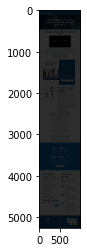

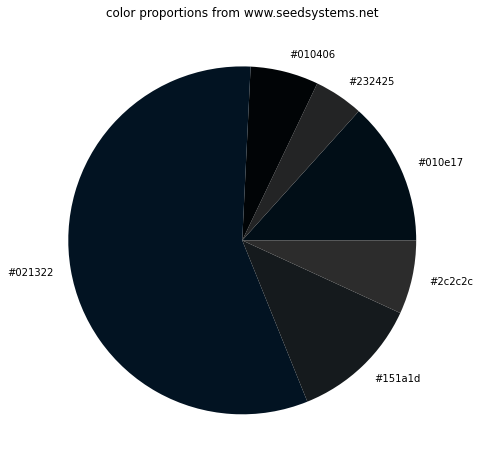

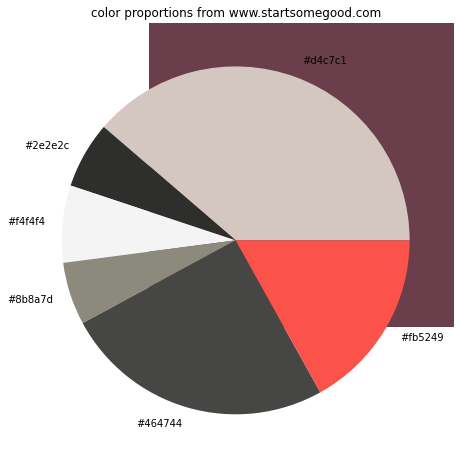

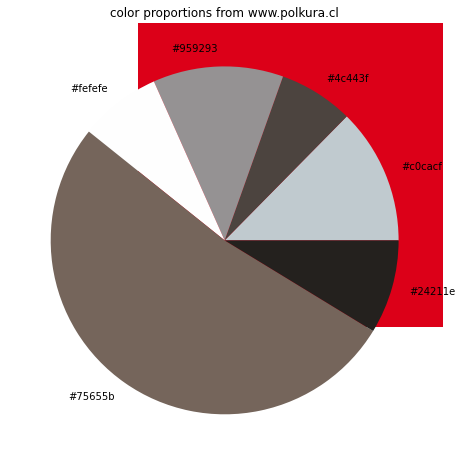

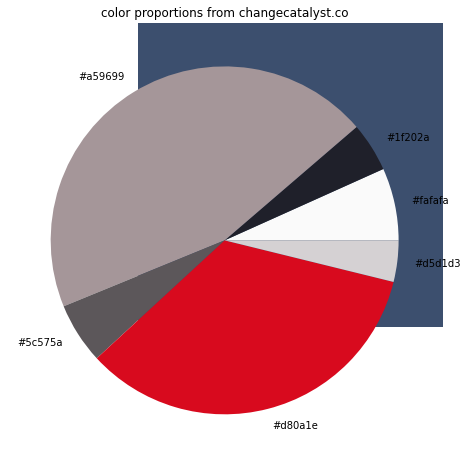

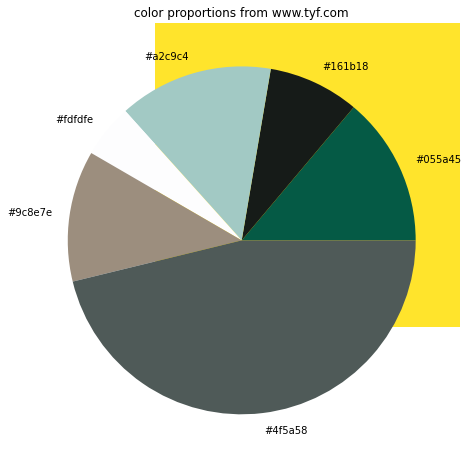

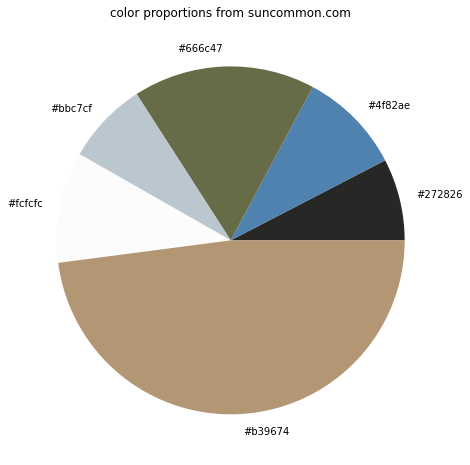

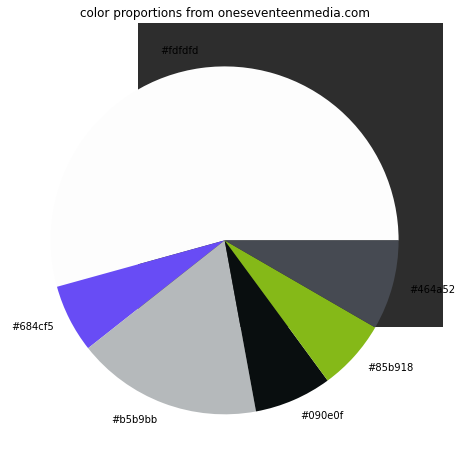

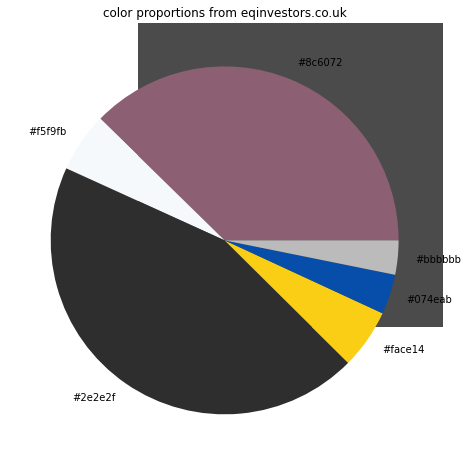

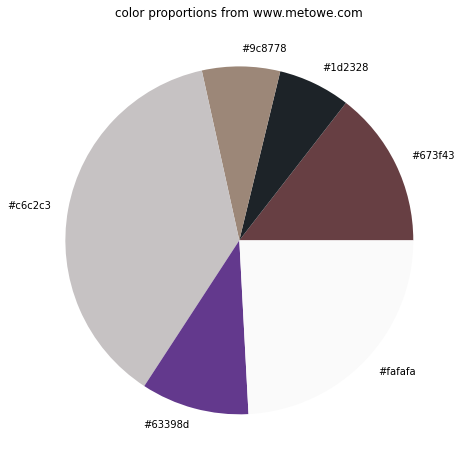

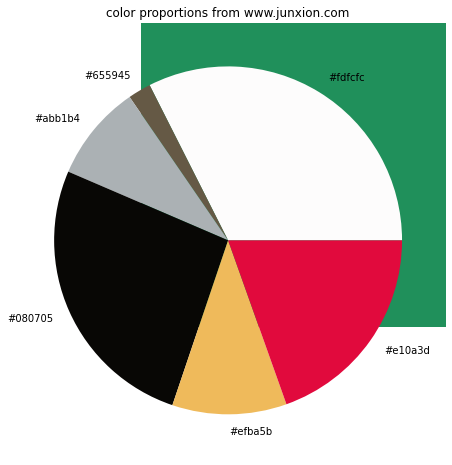

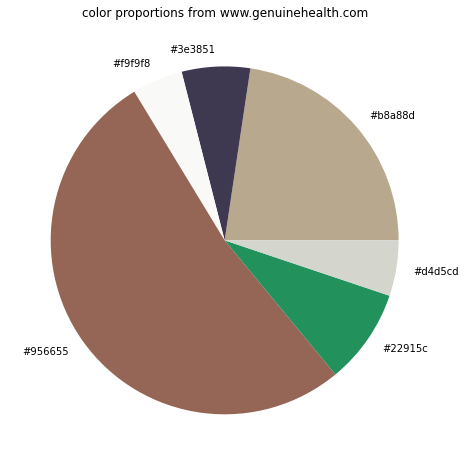

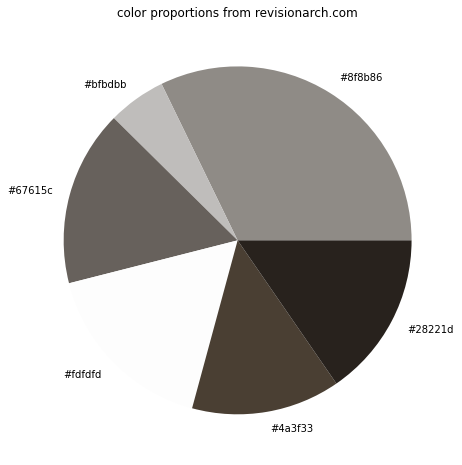

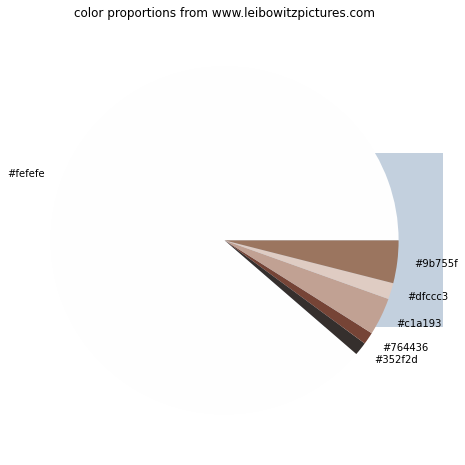

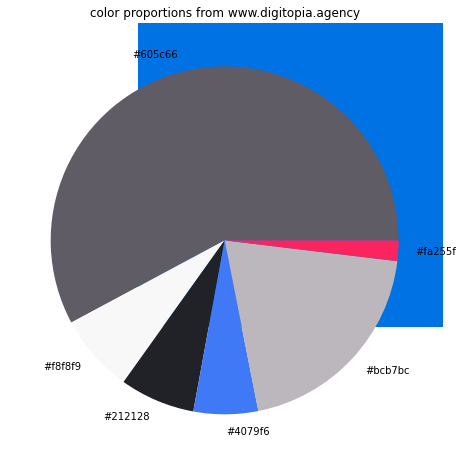

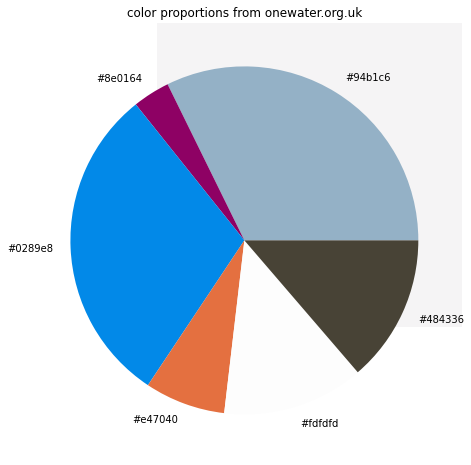

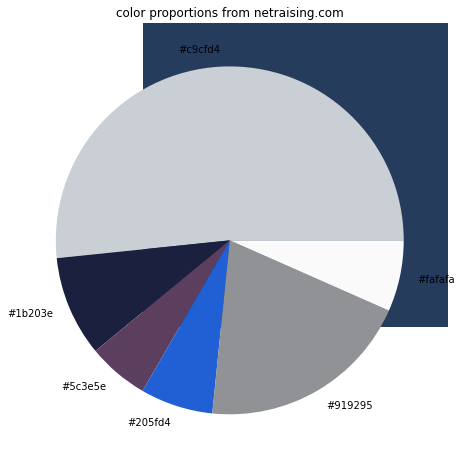

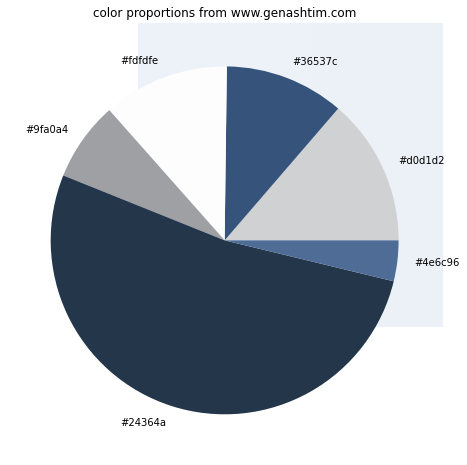

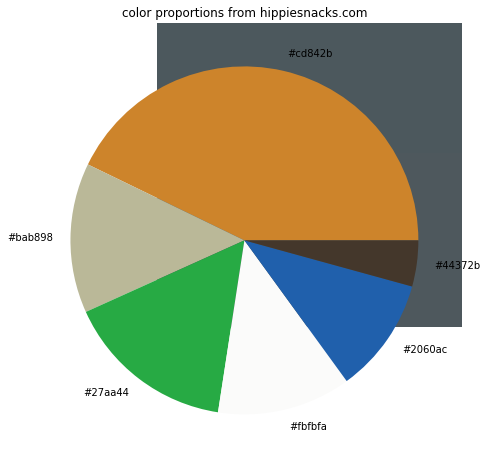

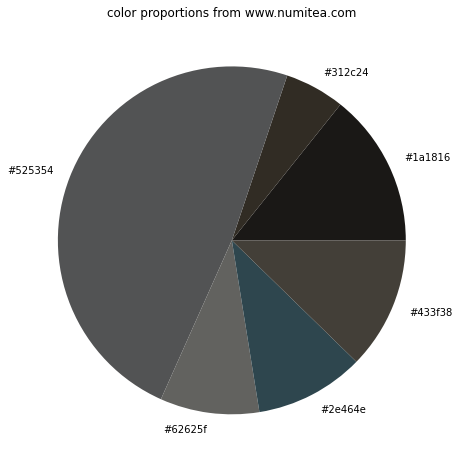

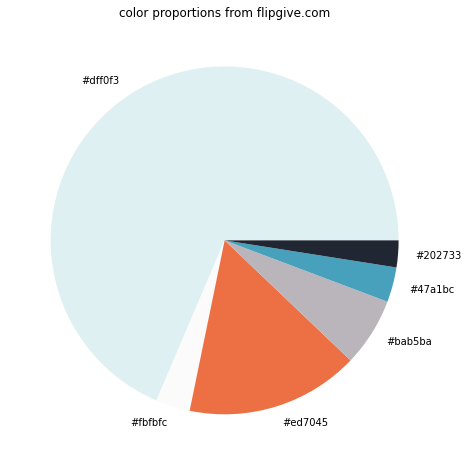

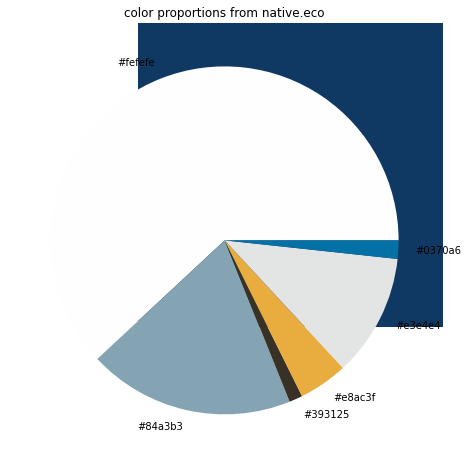

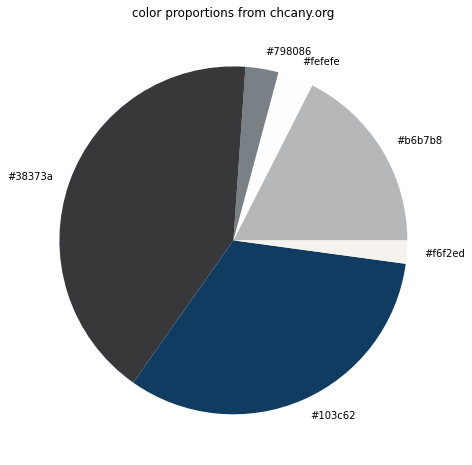

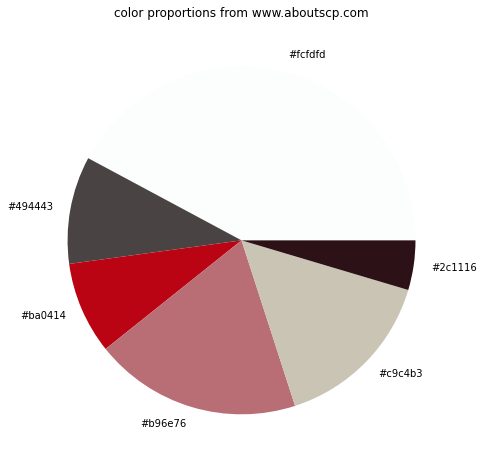

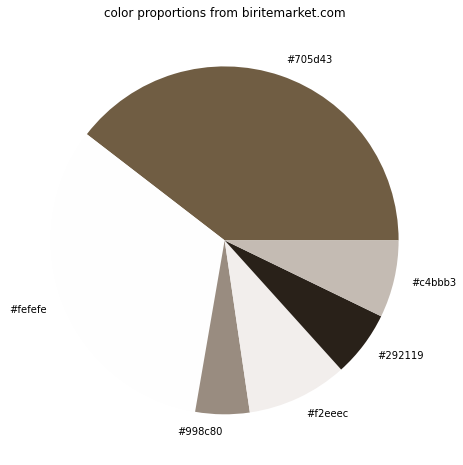

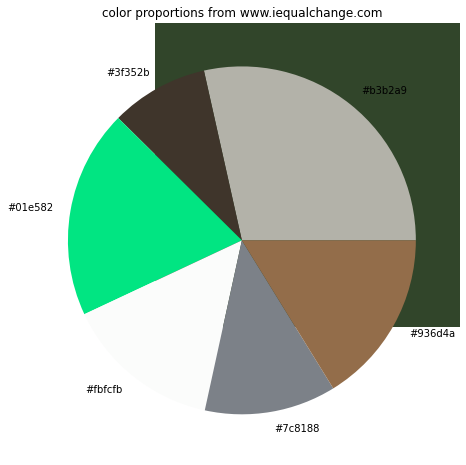

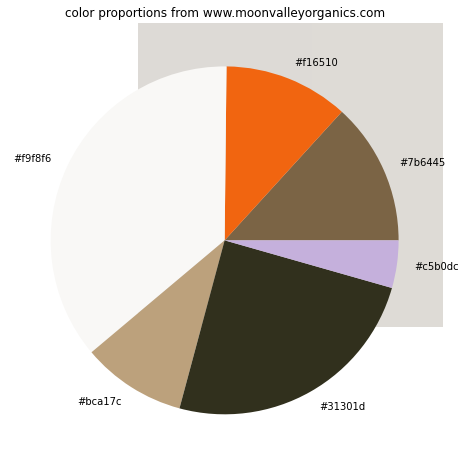

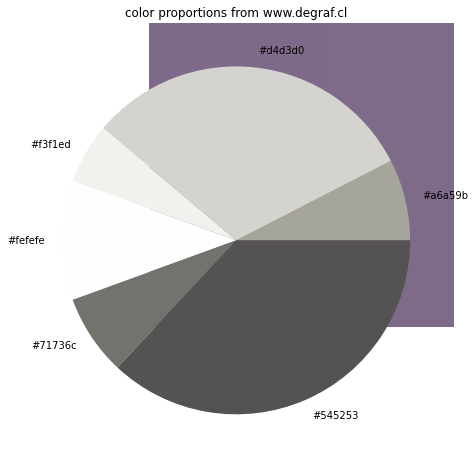

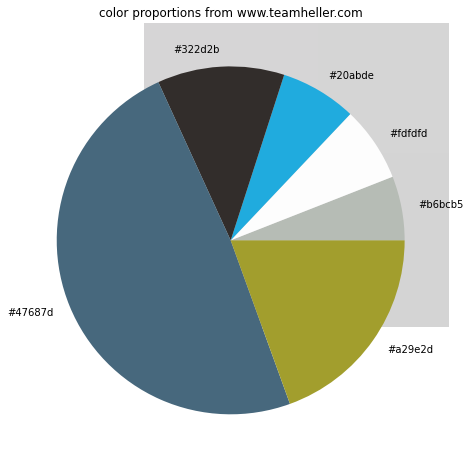

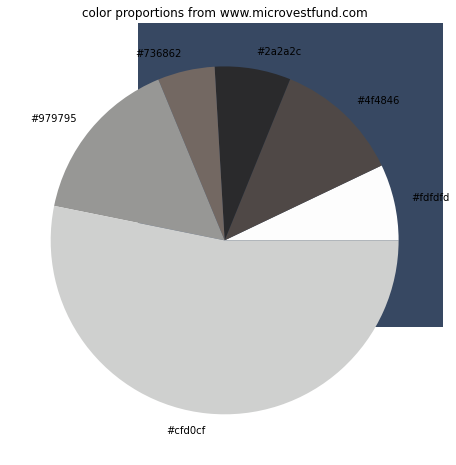

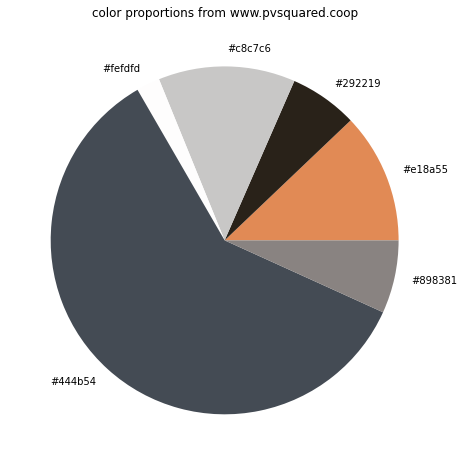

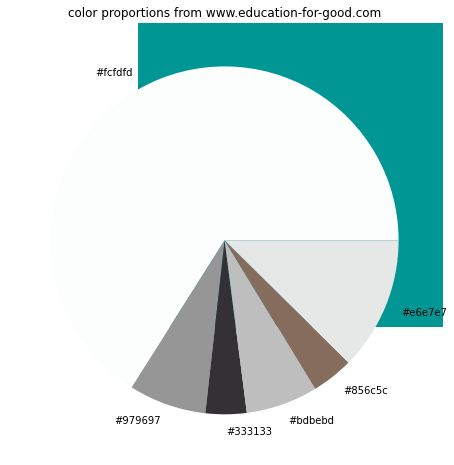

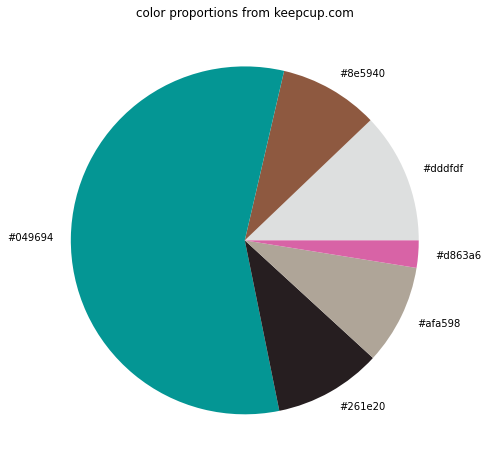

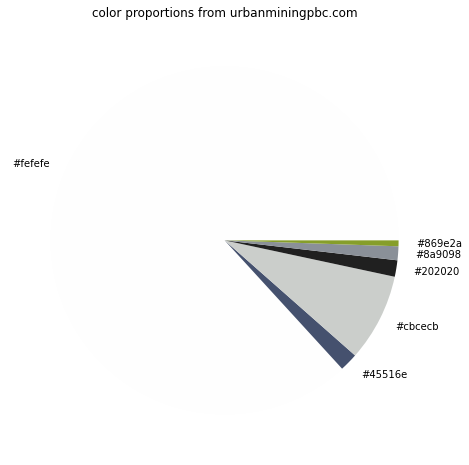

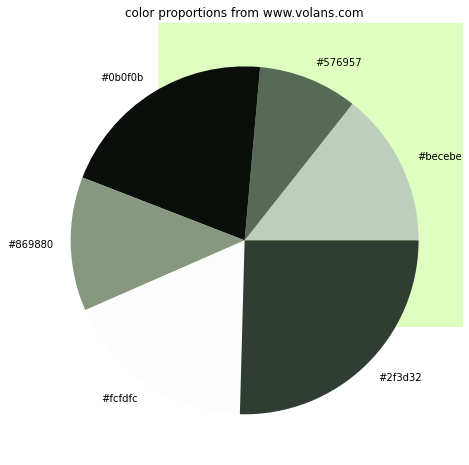

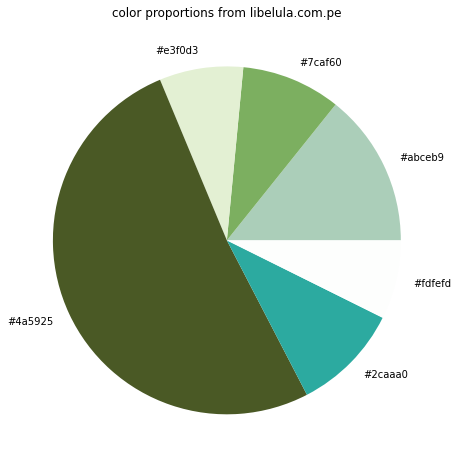

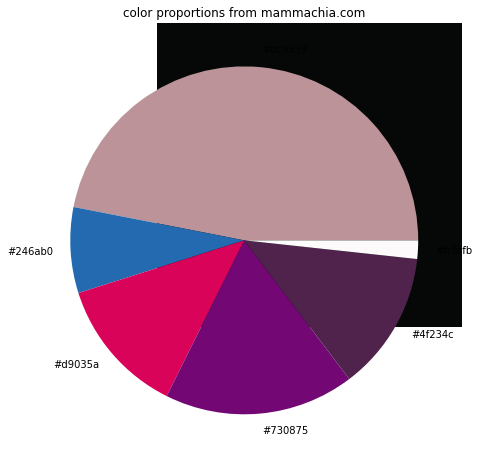

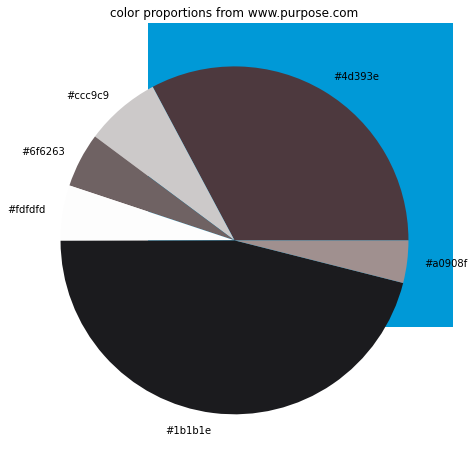

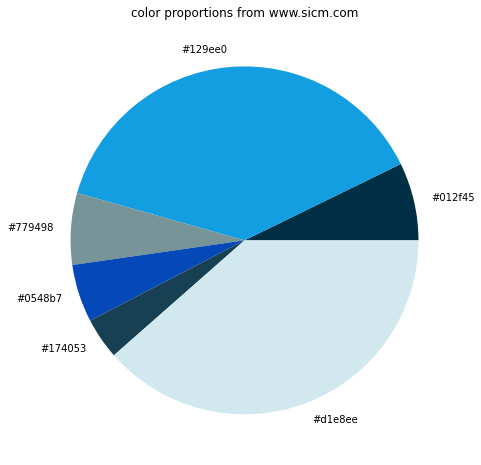

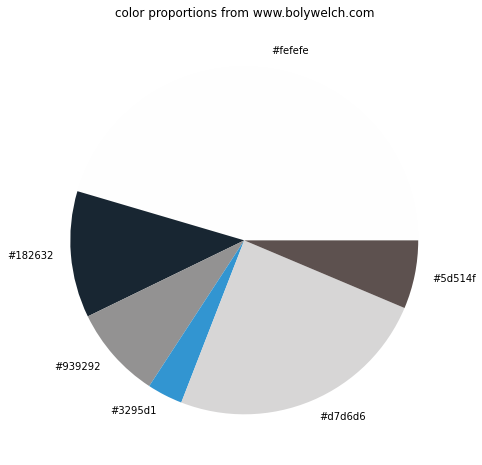

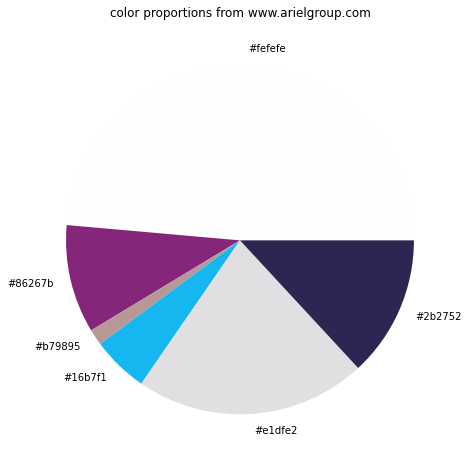

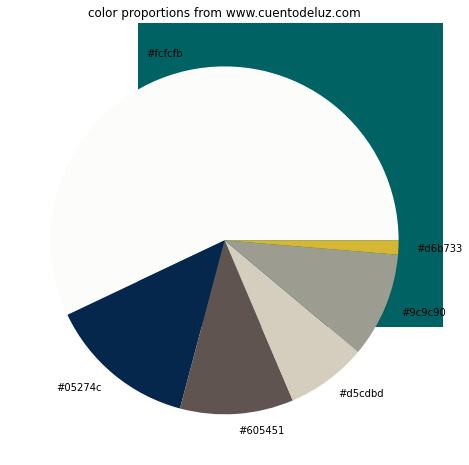

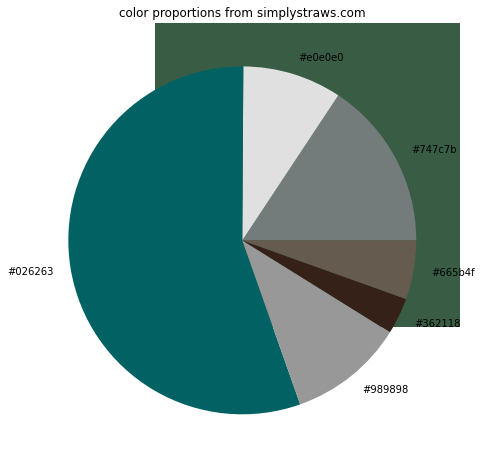

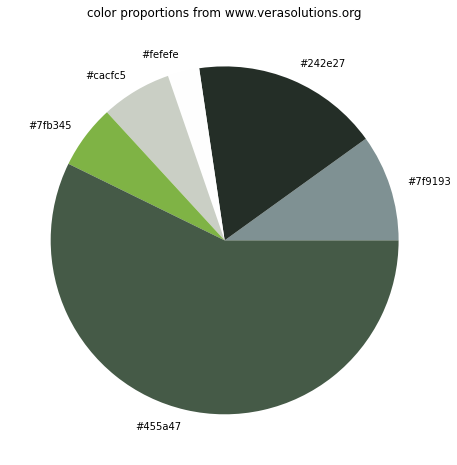

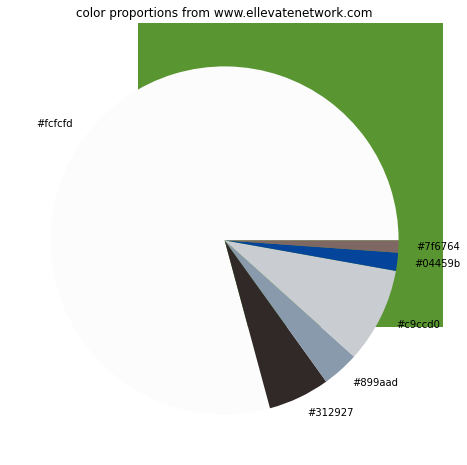

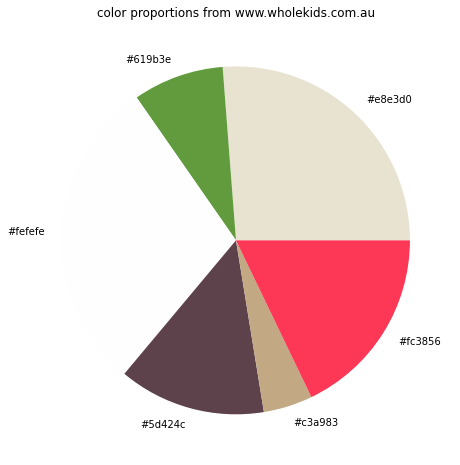

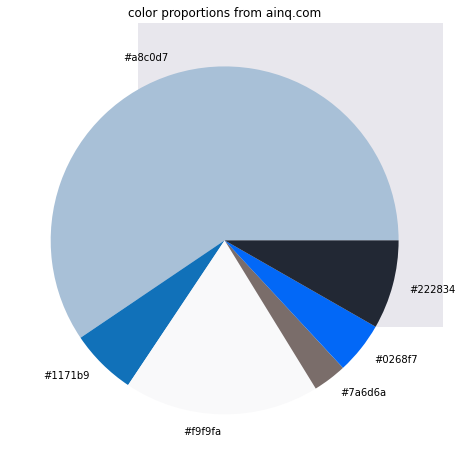

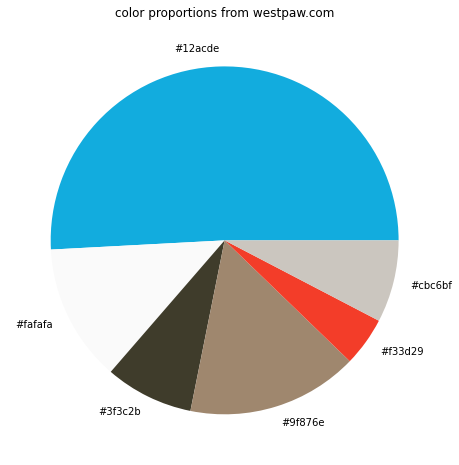

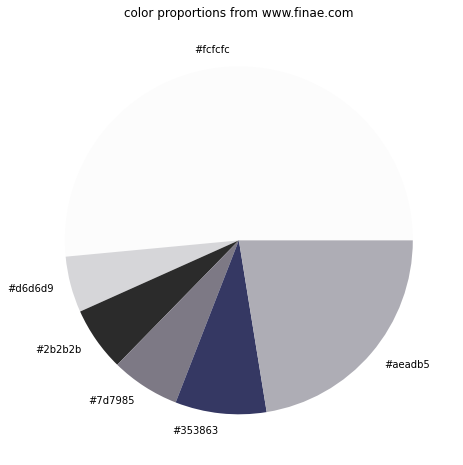

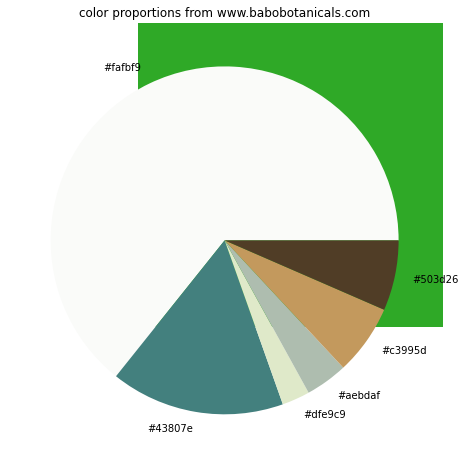

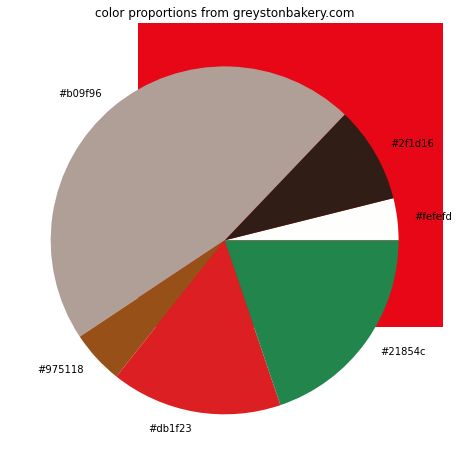

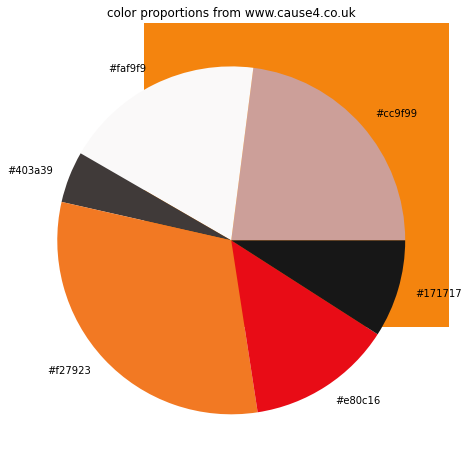

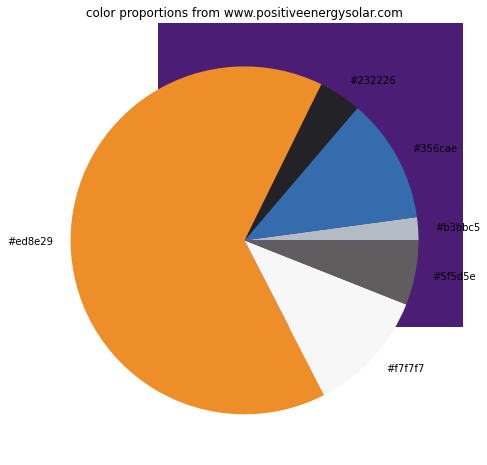

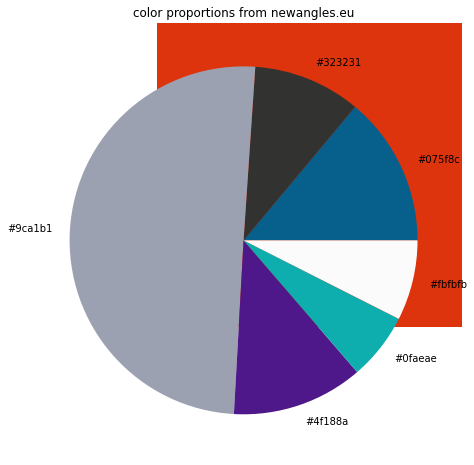

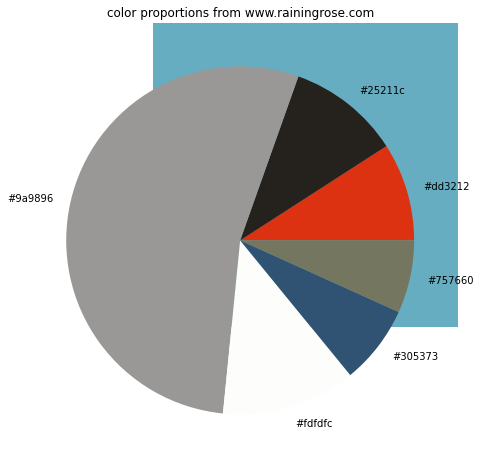

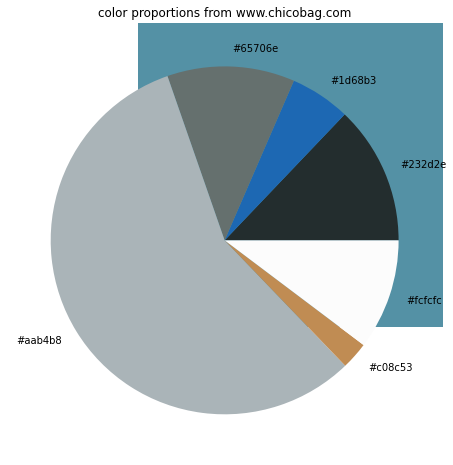

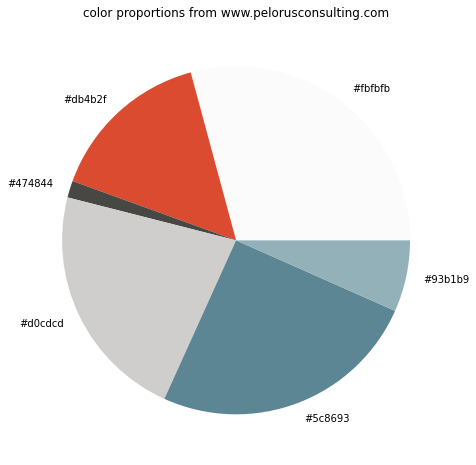

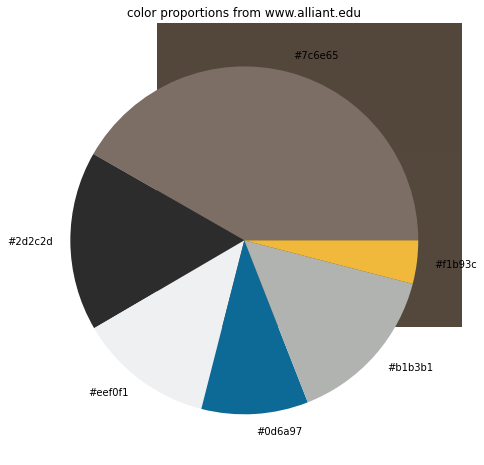

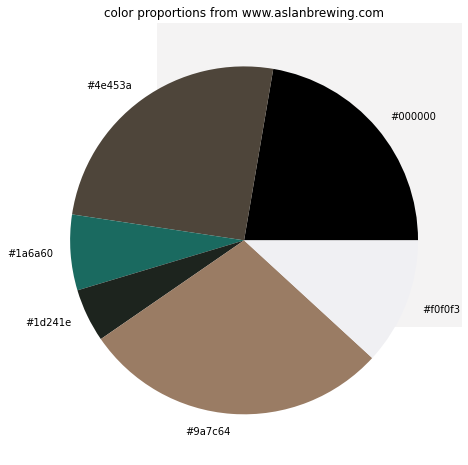

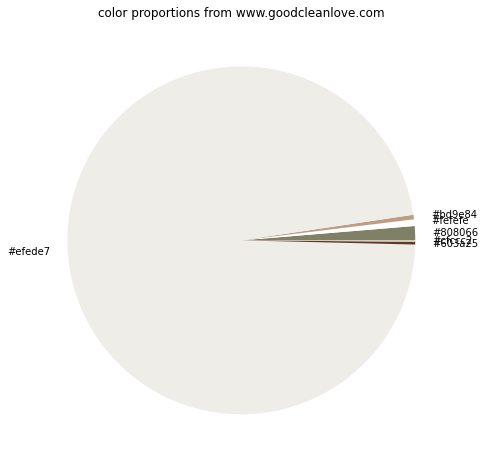

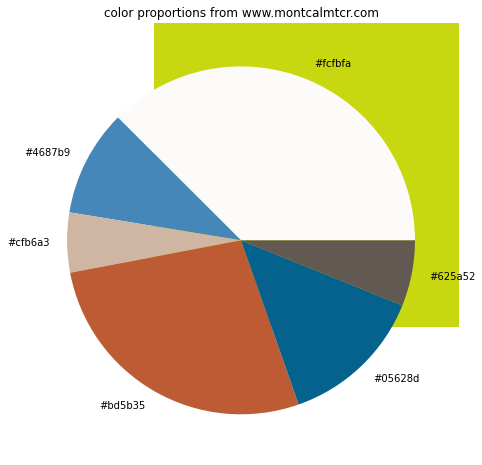

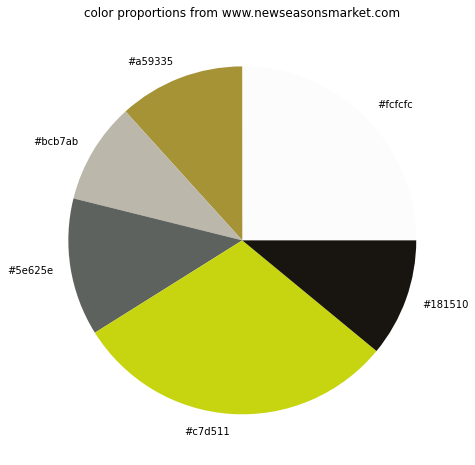

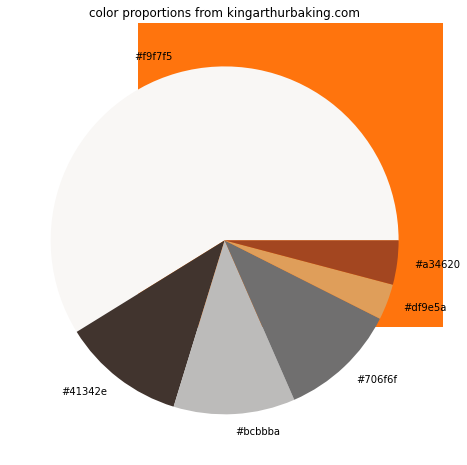

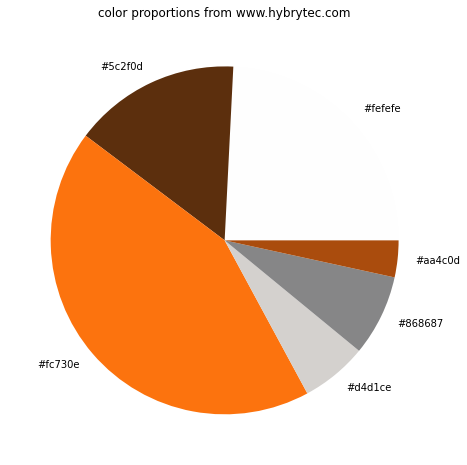

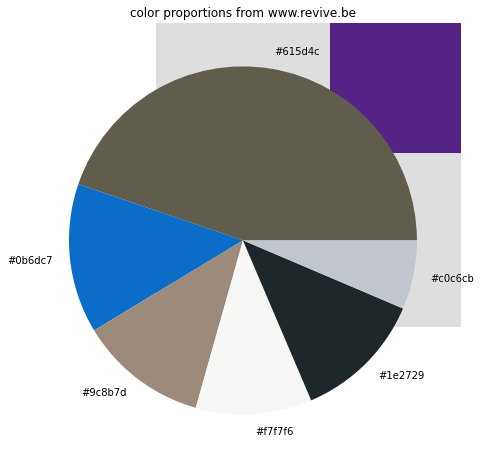

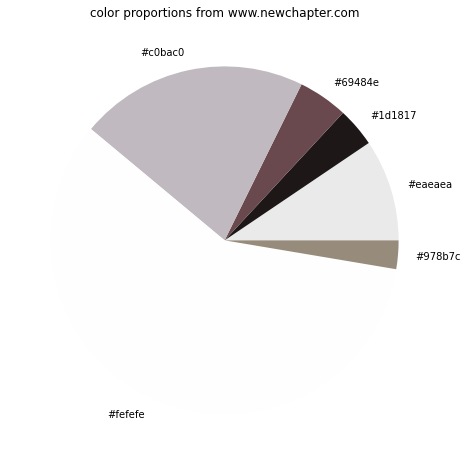

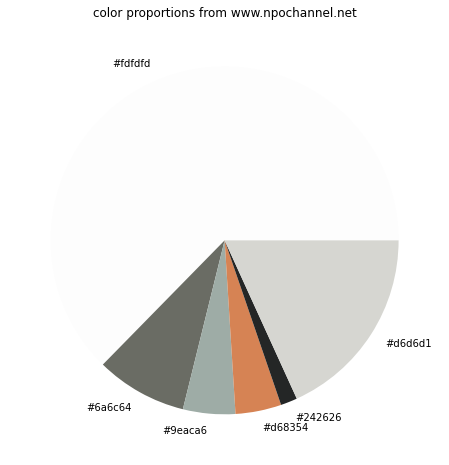

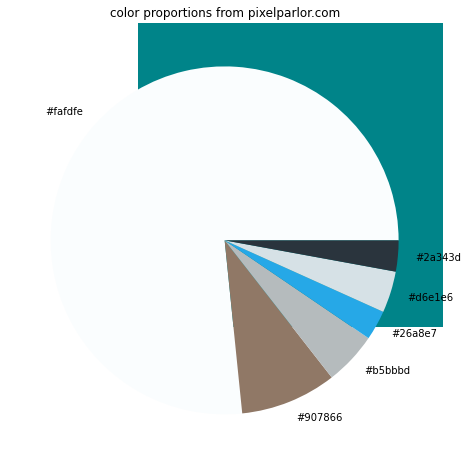

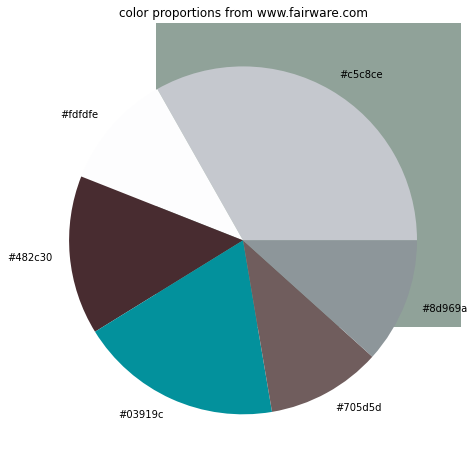

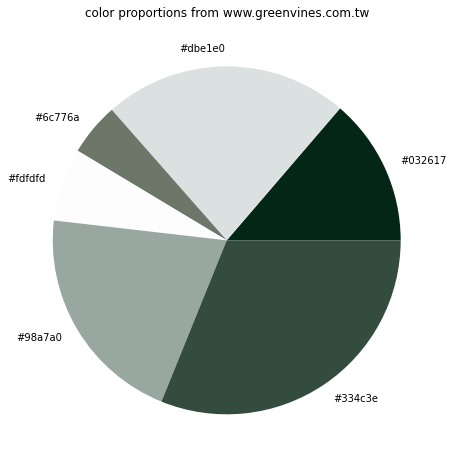

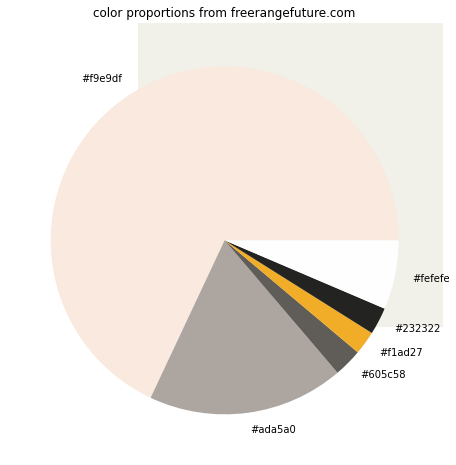

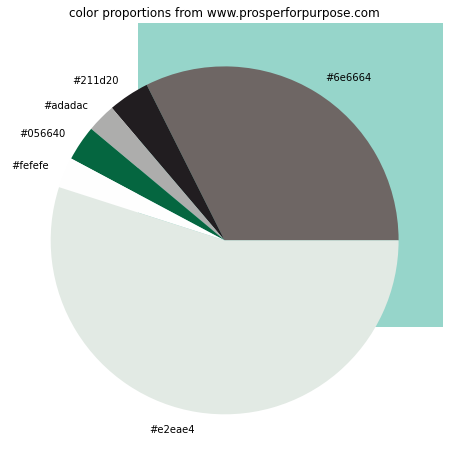

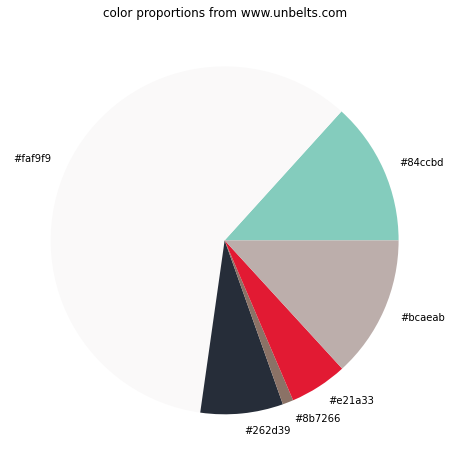

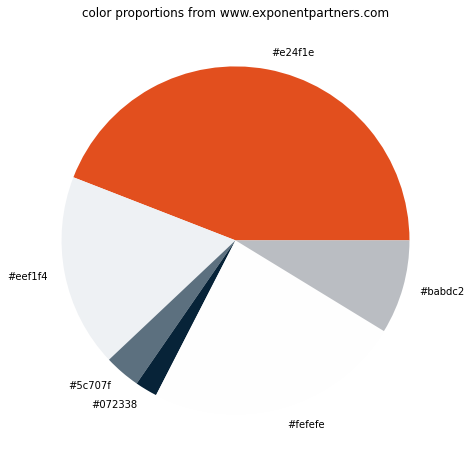

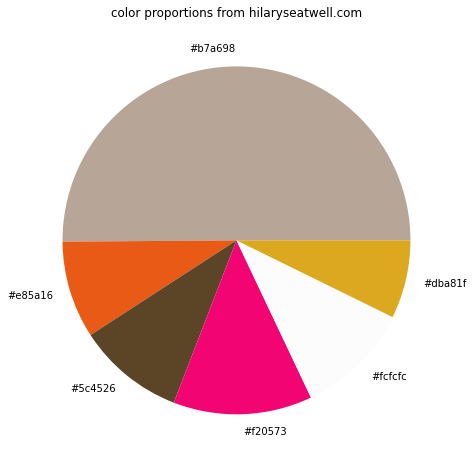

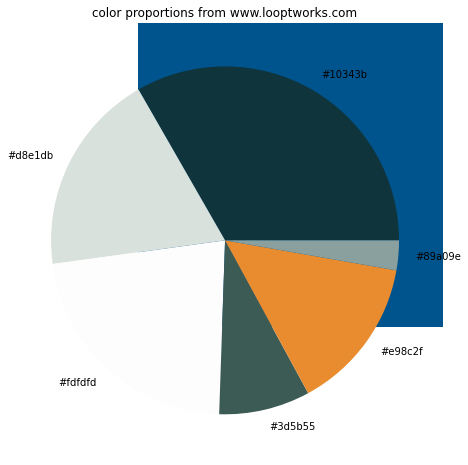

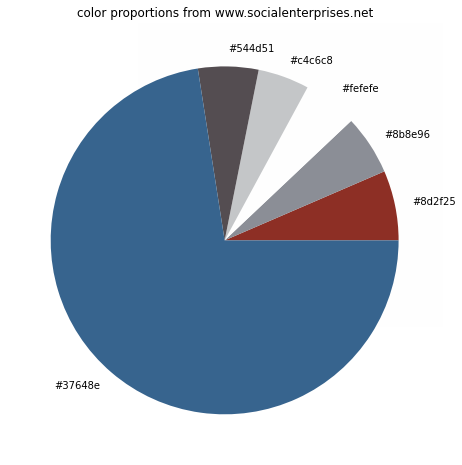

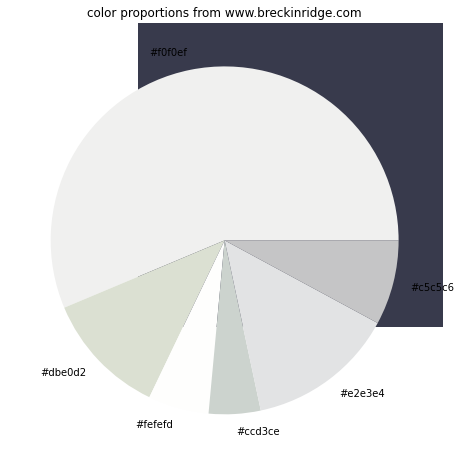

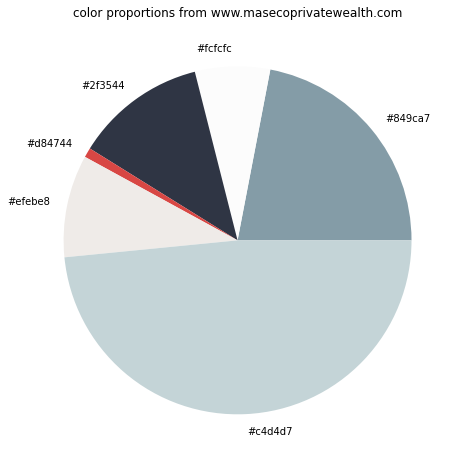

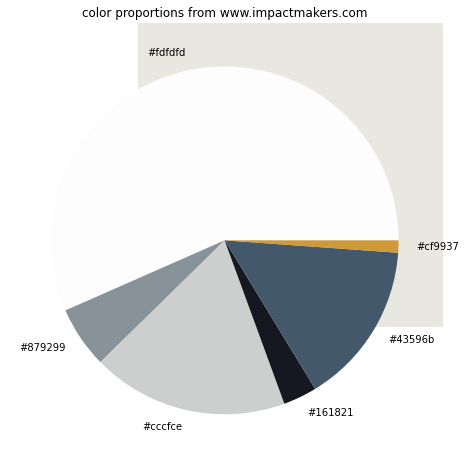

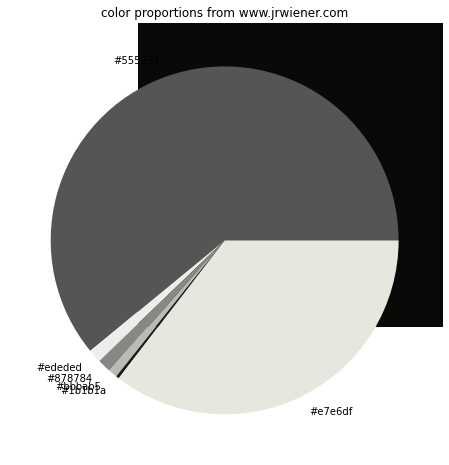

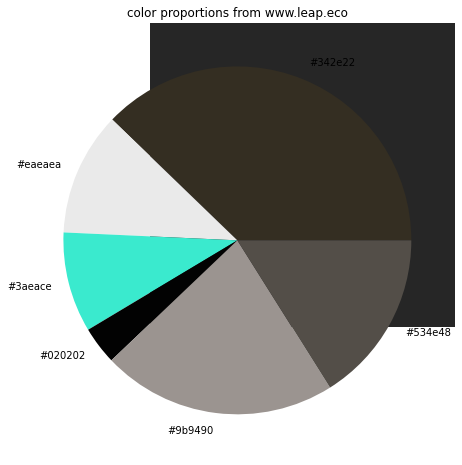

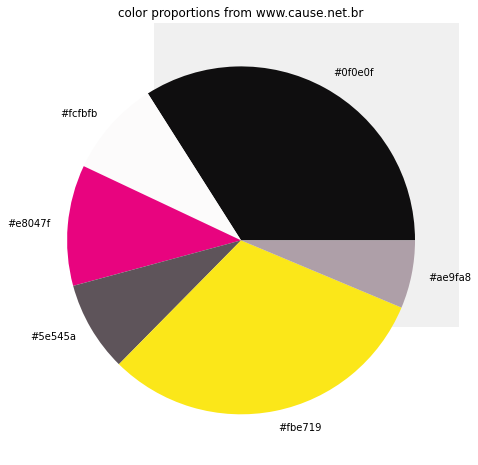

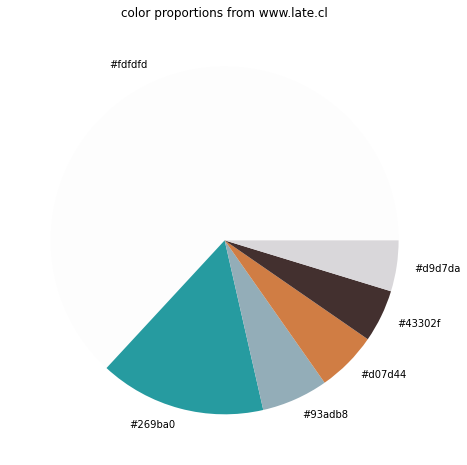

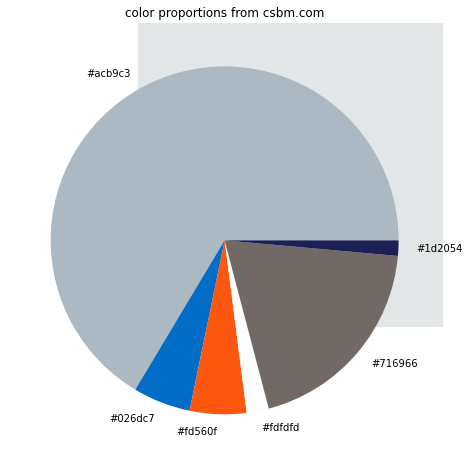

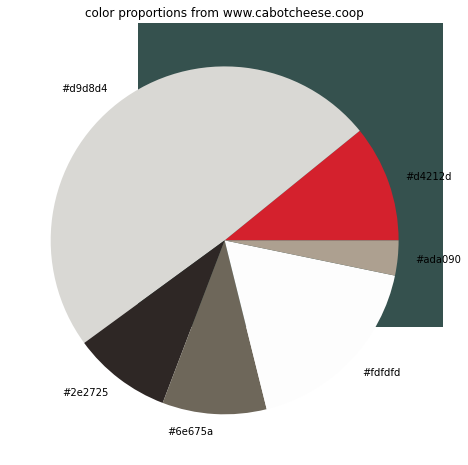

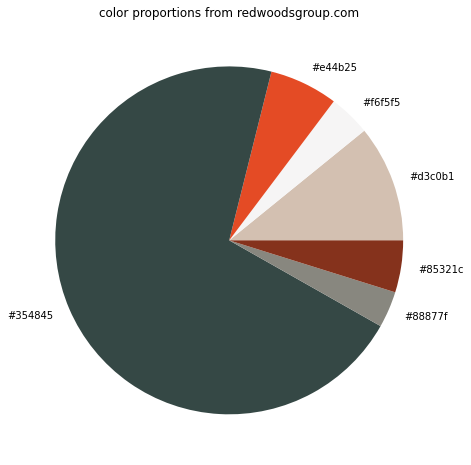

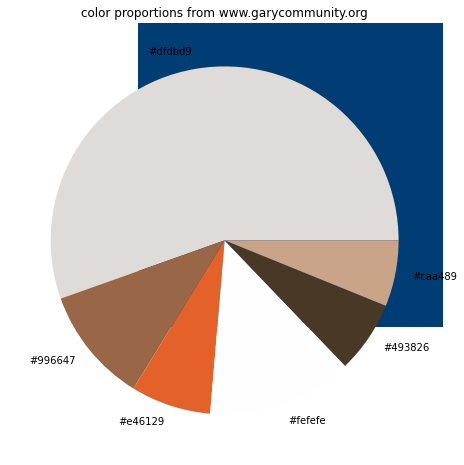

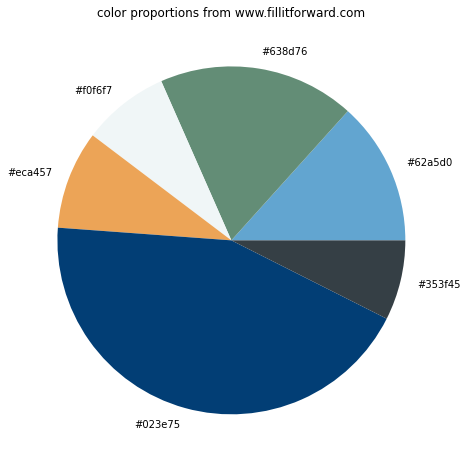

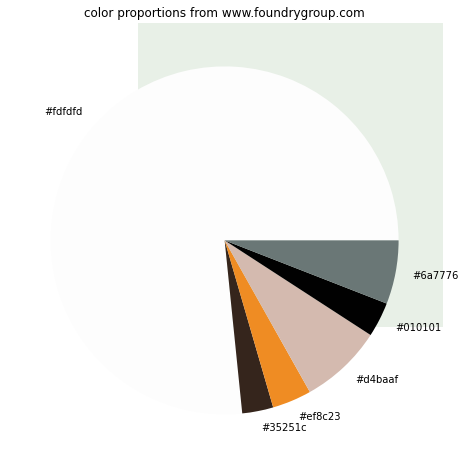

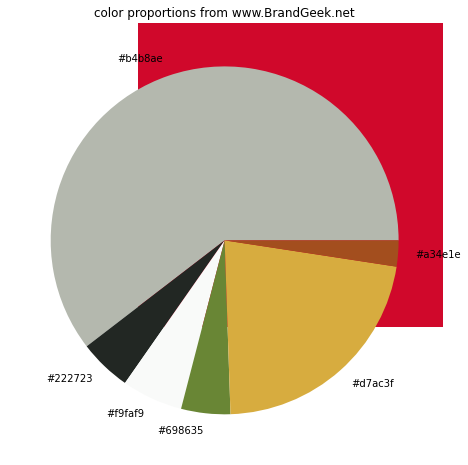

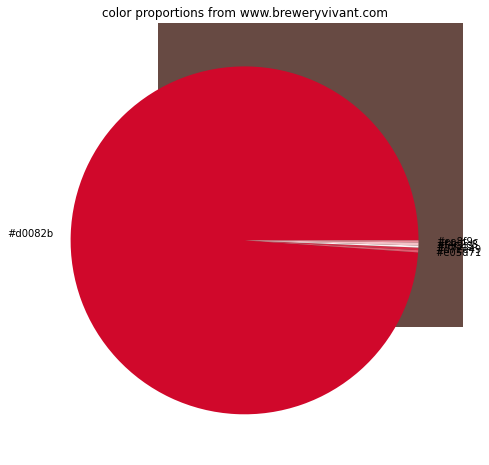

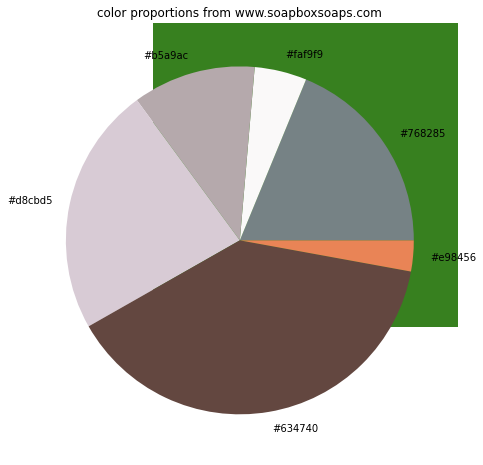

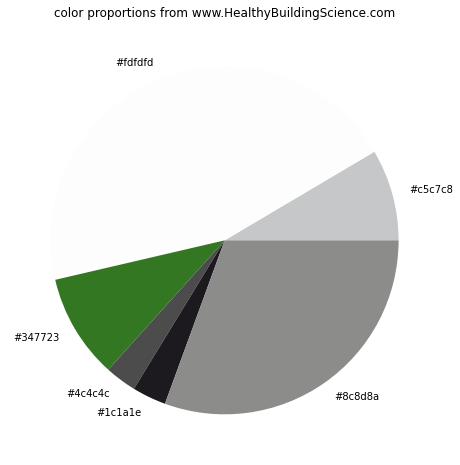

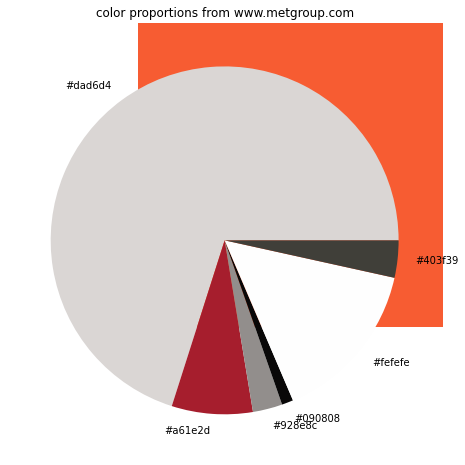

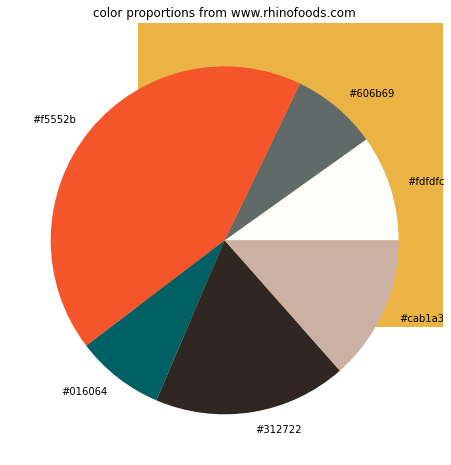

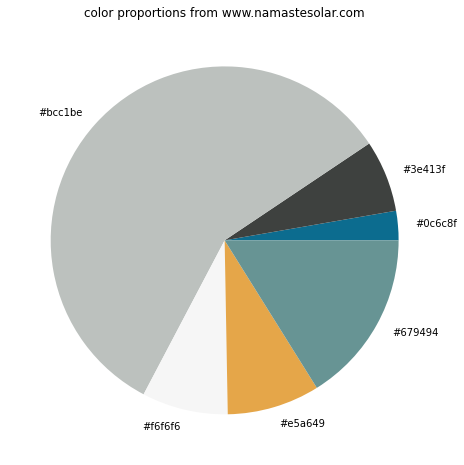

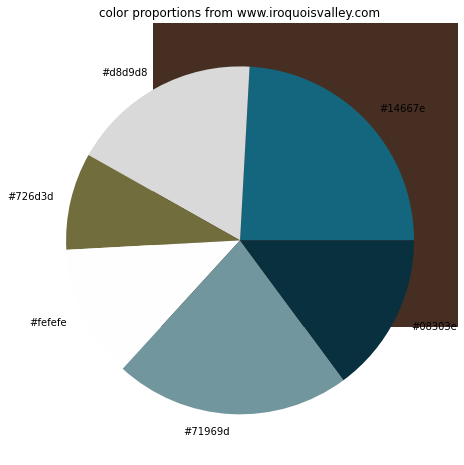

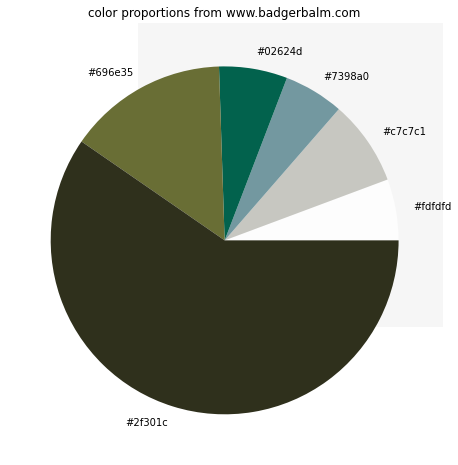

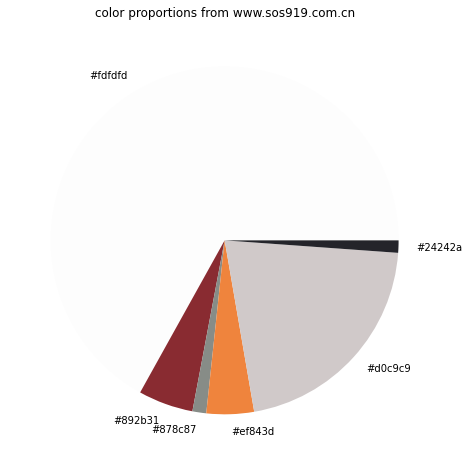

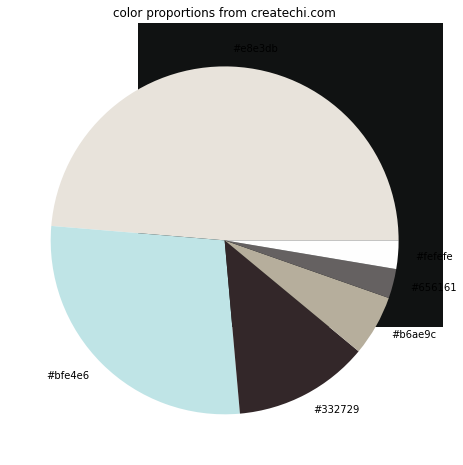

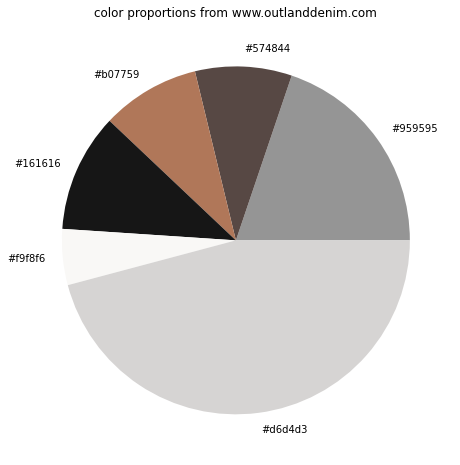

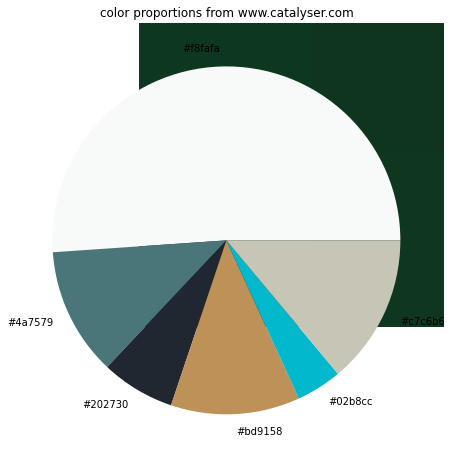

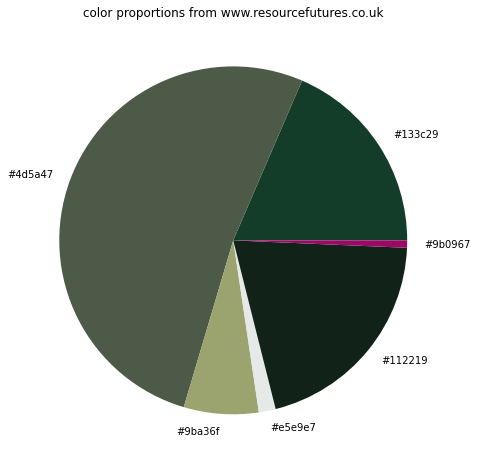

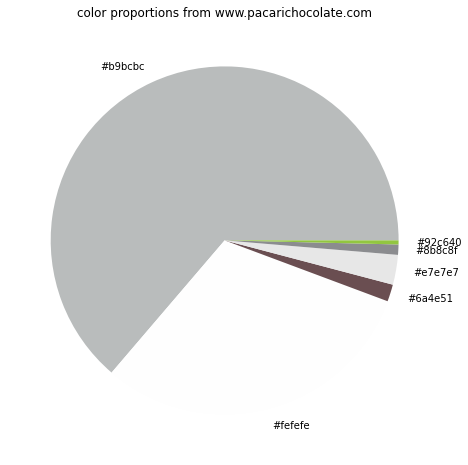

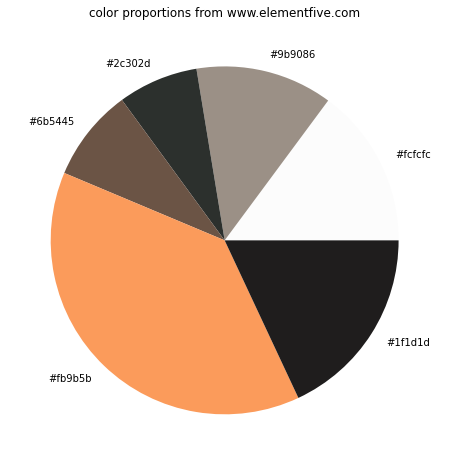

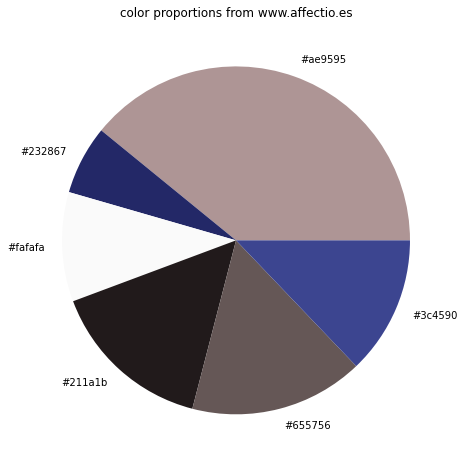

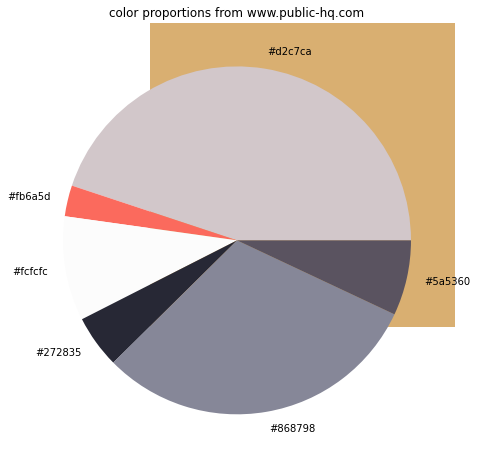

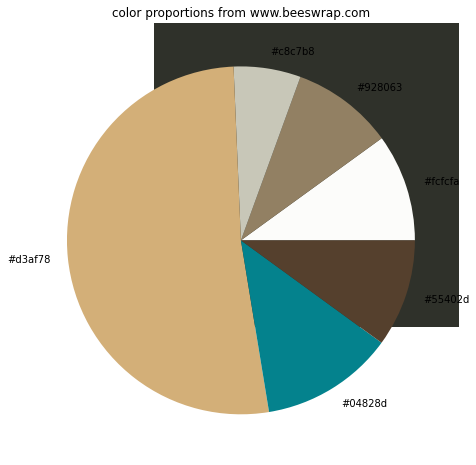

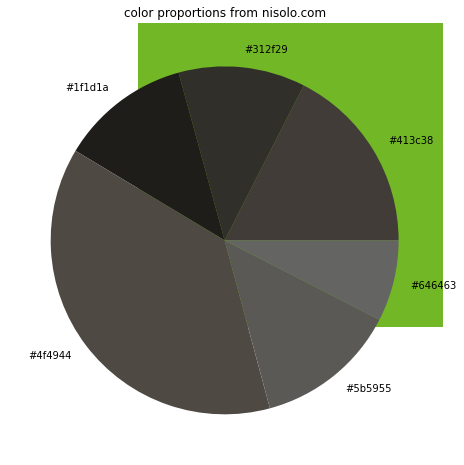

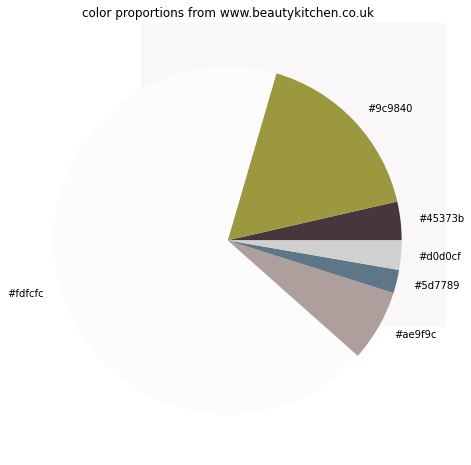

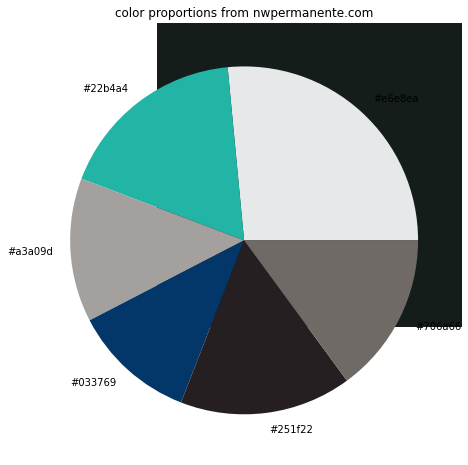

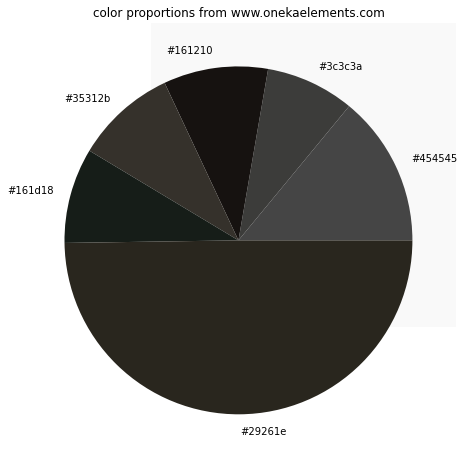

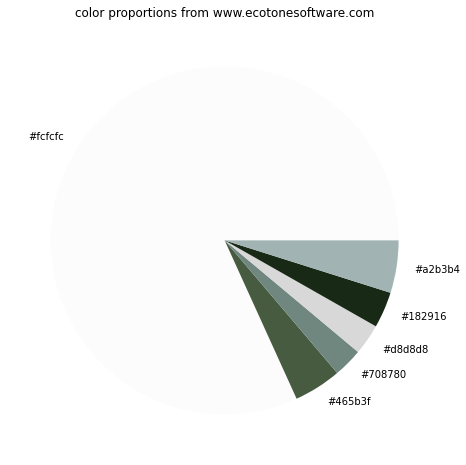

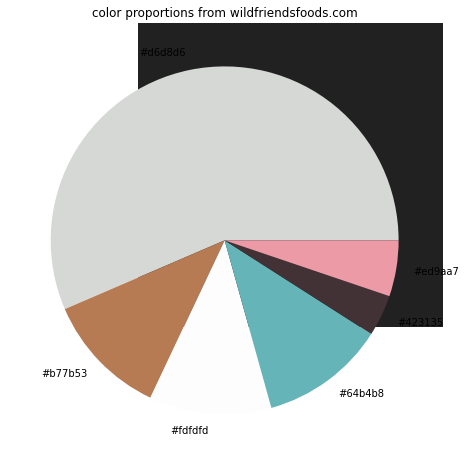

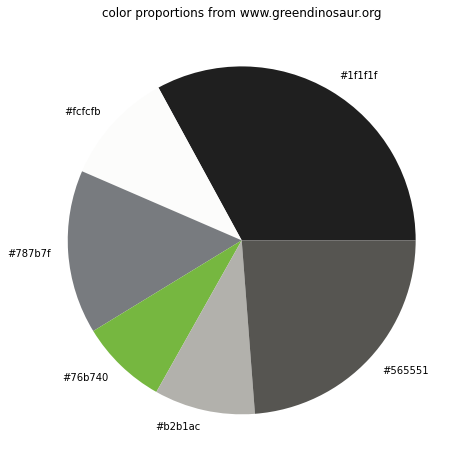

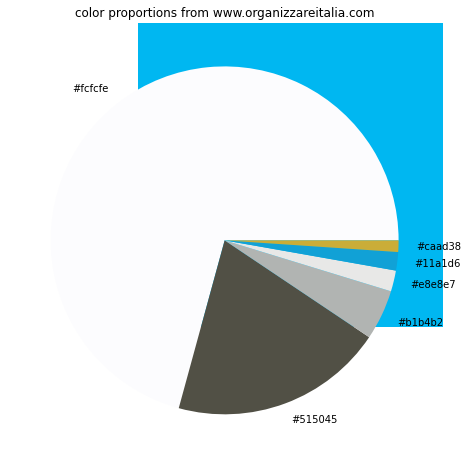

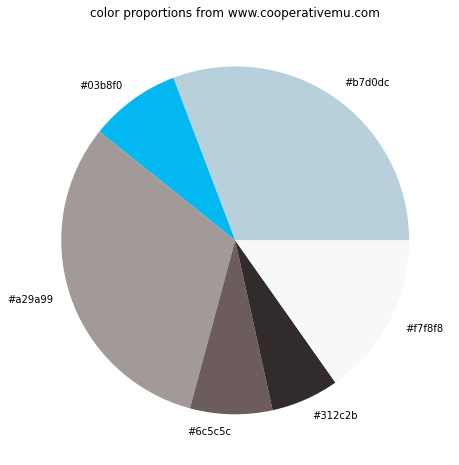

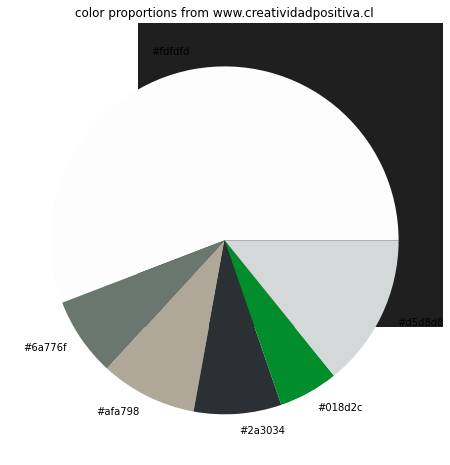

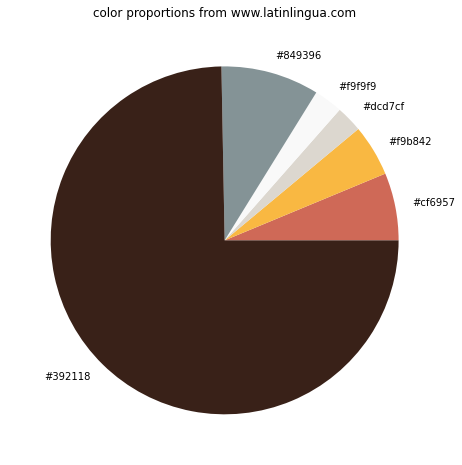

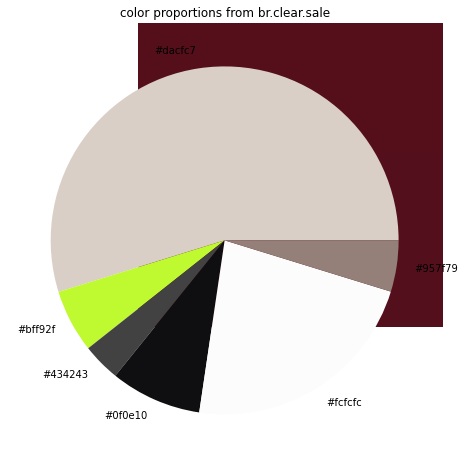

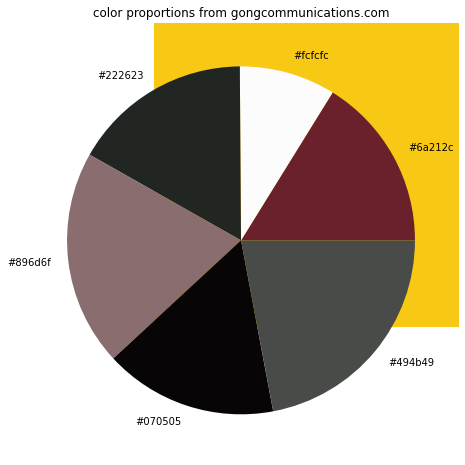

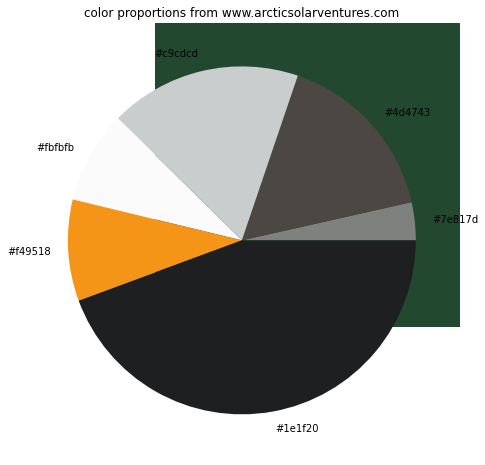

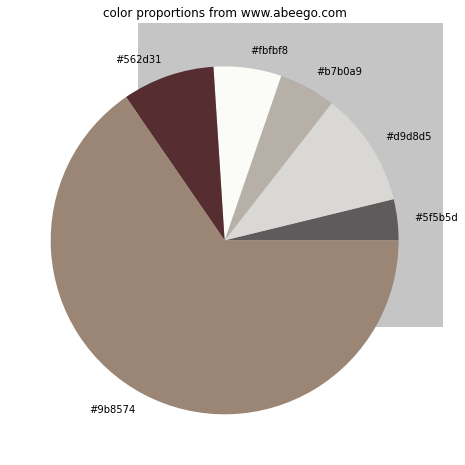

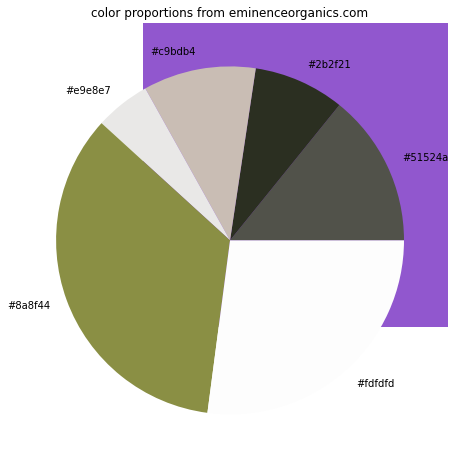

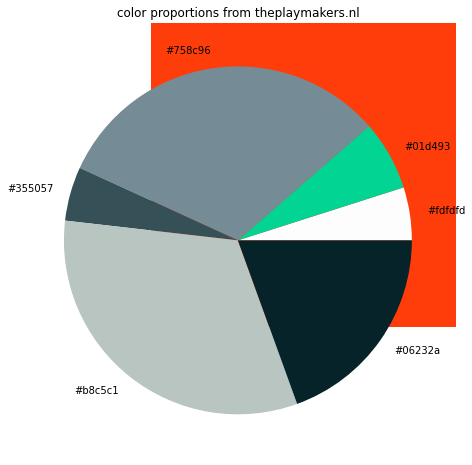

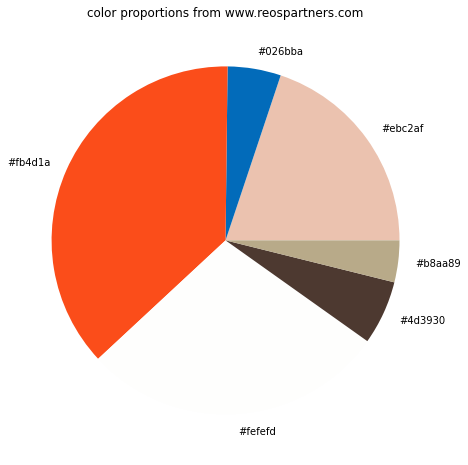

In [8]:
overwrite_json=False
options = webdriver.ChromeOptions()
options.headless = True
options.add_argument(f'user-agent={userAgent}')
    
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
driver.maximize_window()
url_errors = {}
urls_color_dicts = []

if overwrite_json:
    #if the json already exists from a prior code run, delete it
    if os.path.exists('site_screenshot_colors.json'):
        os.remove('site_screenshot_colors.json')

for idx, url in enumerate(company_urls):
    
    
    print(url)
    
    try:
        
        url = url[0]
        
        #take_screenshot(url)
        url = url.split('https://')[1]
        
#         sleep(2)
#         driver.get('https://' + url)
#         #driver.get(url)
#         sleep(2)


#         S = lambda X: driver.execute_script('return document.body.parentNode.scroll'+X)
#         driver.set_window_size(S('Width'),S('Height')) # May need manual adjustment

#         el = driver.find_element(By.TAG_NAME, value='body')
#         el.screenshot('./site-screenshots/'+ url.replace('.', '-') + '.png')

        image = cv2.imread('./site-screenshots/'+ url.replace('.', '-') + '.png')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)

        modified_image = prep_image(image)
        color_dict = color_analysis(modified_image, url)
        color_dict['url'] = url
        color_dict['screenshot'] = url.replace('.', '-') + '.png'
        
        
        
        with open('site_screenshot_colors.json', 'a') as f:
            f.write(json.dumps(color_dict))
            f.write('\n')

                                      

        urls_color_dicts.append(color_dict)
        
        #font family is probably not reliable
#         print(el.value_of_css_property("font-family"))
#         print(el.value_of_css_property("background-color"))
#         print(el.value_of_css_property("color"))
#         print(el.value_of_css_property("font-family"))
#         print(el.value_of_css_property("font-size"))
        
        
        
                
    
    except Exception as e:
        
        print("url {url} error {e}".format(url=url, e=e))
        
        url_errors[url] = e

#driver.quit()
#f.close()

print("end...")

In [9]:
#len(url_errors.keys())
#idx
idx

3557

In [ ]:
full_url = "http://" + url
# hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
#        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
#        'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
#        'Accept-Encoding': 'none',
#        'Accept-Language': 'en-US,en;q=0.8',
#        'Connection': 'keep-alive'}

hdr = {'User-Agent':str(ua.chrome)}

req = Request(full_url,headers=hdr)
page = urlopen(req)
soup = BeautifulSoup(page, 'html.parser')

main_site_text = get_paragraph_text(full_url, hdr).lower()
#print(main_site_text)

processed_text = TextPreprocessor().preprocess_text(main_site_text)
print(processed_text)

word_counts = collections.Counter(processed_text.split())
# bg = bigrams(ah_text.split())
# bigram_counts = collections.Counter(bg)
# tg = trigrams(ah_text.split())
# trigram_counts = collections.Counter(tg)

word_counts.most_common(50)
#bigram_counts.most_common(50)


In [ ]:
#element = driver.find_element(By.XPATH, "/html/body")
#element = driver.find_element(By.TAG_NAME, value='title')

# print(el.value_of_css_property("background-color"))
# print(el.value_of_css_property("color"))
# print(el.value_of_css_property("font-family"))
# print(el.value_of_css_property("font-size"))

In [ ]:
#are the rgb values, cluster centroids, cluster centroid proportions, or hsv values predictive of the type of business

In [ ]:
# #Save this part
# r = requests.get("https://www.bcorporation.net/sitemap/sitemap-0.xml")
# root = etree.fromstring(r.content)
# d='find-a-b-corp'
# hdr = {'User-Agent':str(ua.chrome)}

# urls=[]

# company_urls=[]
# for sitemap in root:
#     children = sitemap.getchildren()
#     #xmlDict[children[0].text] = children[1].text
#     if 'find-a-b-corp/company/' in children[0].text:
#         urls.append(children[0].text)

# for idx, url in enumerate(urls):

#     url_split=url.split('find-a-b-corp')

#     redirect=url_split[0] + 'en-us/' + d + url_split[1]

#     company=redirect.split('/company/')[-1]



#     req = Request(redirect,headers=hdr)
#     page = urlopen(req)
#     soup = BeautifulSoup(page, 'html.parser')

#     company_url=soup.find('a', attrs={'href': re.compile(company)}).get('href')
#     company_urls.append(company_url)


In [30]:
all_centroid_df = pd.DataFrame(columns=['red', 'green', 'blue', 'proportion', 'url'])

for ele in color_data:
    
    centroid_df = pd.DataFrame(ele['centroids_rgb'], columns=['red', 'green', 'blue'])
    centroid_df['proportion'] = ele['color_proportion']
    #centroid_df.assign(url=ele['url'])
    centroid_df.loc[:,'url'] = ele['url']
    
    all_centroid_df = pd.concat([all_centroid_df, centroid_df], axis=0)

#centroid_df

In [31]:
all_centroid_df

red    green     blue proportion                         url
0     2.016    73.41   98.516      0.151  www.sicsamicrofinanzas.com
1   107.774  121.123  114.084      0.094  www.sicsamicrofinanzas.com
2   186.781  217.757  219.477      0.106  www.sicsamicrofinanzas.com
3   252.487  252.977  252.909      0.499  www.sicsamicrofinanzas.com
4     3.807  135.358  187.896      0.019  www.sicsamicrofinanzas.com
..      ...      ...      ...        ...                         ...
1   235.796  194.997  175.931      0.049        www.reospartners.com
2   254.386  254.021  253.852      0.371        www.reospartners.com
3   184.653  170.111  137.356      0.282        www.reospartners.com
4    77.963   57.712   48.049       0.06        www.reospartners.com
5     2.794  107.293  186.263      0.039        www.reospartners.com

[5465 rows x 5 columns]

In [35]:
C=all_centroid_df[['red', 'green', 'blue']].to_numpy()/255

C

array([[0.007905882352941176, 0.2878823529411765, 0.3863372549019608],
       [0.422643137254902, 0.4749921568627451, 0.44738823529411764],
       [0.7324745098039216, 0.8539490196078432, 0.8606941176470588],
       ...,
       [0.7241294117647058, 0.6671019607843137, 0.5386509803921569],
       [0.30573725490196074, 0.22632156862745098, 0.18842745098039215],
       [0.01095686274509804, 0.42075686274509805, 0.730443137254902]],
      dtype=object)

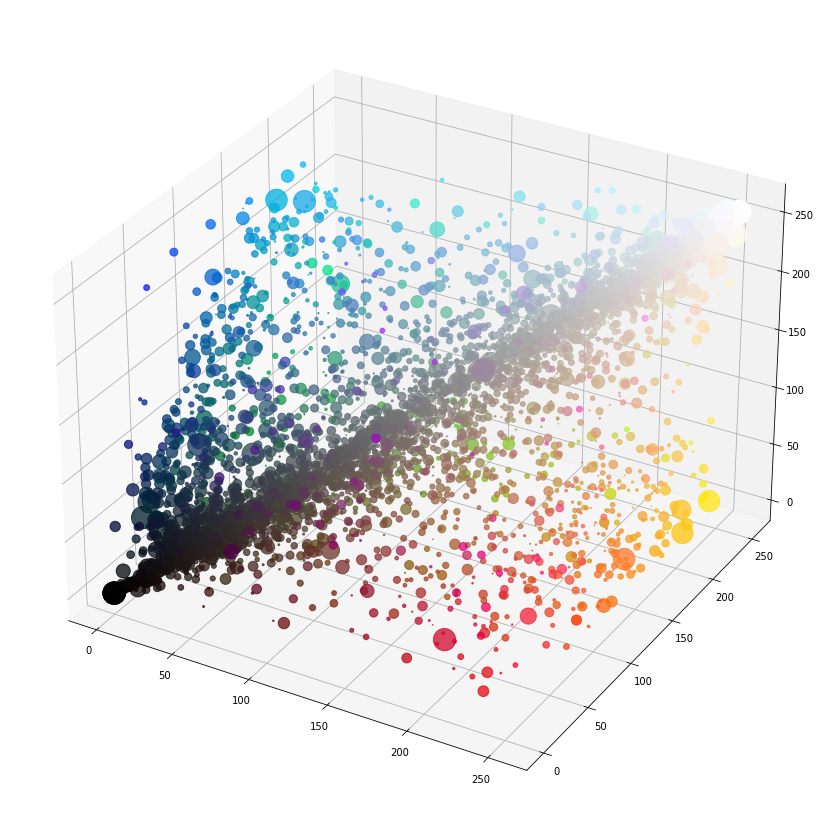

In [47]:
#C=all_centroid_df[['red', 'green', 'blue']].to_numpy()

# temp = df[some_filter]
# temp.plot.scatter(x='x', y='y', s=temp['s'])

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection = '3d')
s = all_centroid_df['proportion'].astype(float)*500

ax.scatter(all_centroid_df['red'], all_centroid_df['green'], all_centroid_df['blue'], c = C, s=s, alpha=.75)
plt.show()

In [11]:
#f = open('site_screenshot_colors.json')
  
# returns JSON object as 
# a dictionary
color_data = []

for line in open('site_screenshot_colors.json', 'r'):
    color_data.append(json.loads(line))

In [17]:
color_data

[{'centroids_rgb': [[2.016, 73.41, 98.516],
   [107.774, 121.123, 114.084],
   [186.781, 217.757, 219.477],
   [252.487, 252.977, 252.909],
   [3.807, 135.358, 187.896],
   [34.063, 48.948, 53.396]],
  'centroids_hex': ['#fcfcfc',
   '#223035',
   '#024962',
   '#bad9db',
   '#6b7972',
   '#0387bb'],
  'color_counts': [81356, 50685, 57476, 269456, 10178, 70849],
  'color_proportion': [0.151, 0.094, 0.106, 0.499, 0.019, 0.131],
  'centroids_hsv': [[0.5433609671848014, 0.9795363189735677, 98.516],
   [0.4121157639773267, 0.11021028210992134, 121.123],
   [0.5087676372237175, 0.1489723296746356, 219.477],
   [0.476870748299316, 0.0019369349782786937, 252.977],
   [0.547565760764268, 0.9797387916719889, 187.896],
   [0.5383454887153226, 0.3620683197243239, 53.396]],
  'url': 'www.sicsamicrofinanzas.com',
  'screenshot': 'www-sicsamicrofinanzas-com.png'},
 {'centroids_rgb': [[254.685, 254.69, 254.699],
   [210.338, 199.746, 199.988],
   [250.328, 186.872, 22.675],
   [147.827, 133.957, 128.

In [ ]:
# # websplit=soup.text.split("Website")
# # print(websplit[1].split('www.')[1].split('.')[0])
# #websplit=soup.text.split("Website")[1].split('www.')[1].split('.')[0]
# #print(websplit)
# #soup.text.split("Website")[1].split('www.')[1].split('.')[0]
# redirect="https://www.bcorporation.net/en-us/find-a-b-corp/company/redemption-rock-brewing-co"
# req = Request(redirect,headers=hdr)
# page = urlopen(req)
# soup = BeautifulSoup(page, 'html.parser')
# for ele in soup.text.split("Website")[1].split('www.'):
#     if len(ele) > 0:
#         company_site = ele.split('.')[0]
#         break


# #[1].split('www.')
# #[0].split('.')[0]

In [ ]:
ax = plt.axes(projection = '3d')